<a href="https://colab.research.google.com/github/garciapg/Predicting-Production-Failures-using-Classification-Models-and-Pipelines/blob/main/ReneWind_Classification_with_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Production Failures using Classification Models and Pipelines

### Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Dictionary
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [ ]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

## Loading the dataset

In [ ]:
df = pd.read_csv('/content/Train.csv.csv')
df_test = pd.read_csv('/content/Test.csv.csv')

## Data Overview

In [ ]:
print(df.shape)
df.head()

(20000, 41)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


- 40 independent variables and 1 dependent variable. All with 20.000 rows.

In [ ]:
print(df_test.shape)
df_test.head()

(5000, 41)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

- All predictors are float type, and just V1 and V2 have a few missing values. The target variable is an integer and no missing values.

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

- Also some missing values, we'll treat them. EVerything else is ok.

### Duplicates

In [ ]:
duplicates = df.duplicated()
duplicates.value_counts()

False    20000
dtype: int64

- There are no duplicates

In [ ]:
duplicates_t = df_test.duplicated()
duplicates_t.value_counts()

False    5000
dtype: int64

- No duplicates in the test set

### Statistical summary

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,19982.000,19982.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000
mean,-0.272,0.440,2.485,-0.083,-0.054,-0.995,-0.879,-0.548,-0.017,-0.013,-1.895,1.605,1.580,-0.951,-2.415,-2.925,-0.134,1.189,1.182,0.024,-3.611,0.952,-0.366,1.134,-0.002,1.874,-0.612,-0.883,-0.986,-0.016,0.487,0.304,0.050,-0.463,2.230,1.515,0.011,-0.344,0.891,-0.876,0.056
std,3.442,3.151,3.389,3.432,2.105,2.041,1.762,3.296,2.161,2.193,3.124,2.930,2.875,1.790,3.355,4.222,3.345,2.592,3.397,3.669,3.568,1.652,4.032,3.912,2.017,3.435,4.369,1.918,2.684,3.005,3.461,5.500,3.575,3.184,2.937,3.801,1.788,3.948,1.753,3.012,0.229
min,-11.876,-12.320,-10.708,-15.082,-8.603,-10.227,-7.950,-15.658,-8.596,-9.854,-14.832,-12.948,-13.228,-7.739,-16.417,-20.374,-14.091,-11.644,-13.492,-13.923,-17.956,-10.122,-14.866,-16.387,-8.228,-11.834,-14.905,-9.269,-12.579,-14.796,-13.723,-19.877,-16.898,-17.985,-15.350,-14.833,-5.478,-17.375,-6.439,-11.024,0.000
25%,-2.737,-1.641,0.207,-2.348,-1.536,-2.347,-2.031,-2.643,-1.495,-1.411,-3.922,-0.397,-0.224,-2.171,-4.415,-5.634,-2.216,-0.404,-1.050,-2.433,-5.930,-0.118,-3.099,-1.468,-1.365,-0.338,-3.652,-2.171,-2.787,-1.867,-1.818,-3.420,-2.243,-2.137,0.336,-0.944,-1.256,-2.988,-0.272,-2.940,0.000
50%,-0.748,0.472,2.256,-0.135,-0.102,-1.001,-0.917,-0.389,-0.068,0.101,-1.921,1.508,1.637,-0.957,-2.383,-2.683,-0.015,0.883,1.279,0.033,-3.533,0.975,-0.262,0.969,0.025,1.951,-0.885,-0.891,-1.176,0.184,0.490,0.052,-0.066,-0.255,2.099,1.567,-0.128,-0.317,0.919,-0.921,0.000
75%,1.840,2.544,4.566,2.131,1.340,0.380,0.224,1.723,1.409,1.477,0.119,3.571,3.460,0.271,-0.359,-0.095,2.069,2.572,3.493,2.512,-1.266,2.026,2.452,3.546,1.397,4.130,2.189,0.376,0.630,2.036,2.731,3.762,2.255,1.437,4.064,3.984,1.176,2.279,2.058,1.120,0.000
max,15.493,13.089,17.091,13.236,8.134,6.976,8.006,11.679,8.138,8.108,11.826,15.081,15.420,5.671,12.246,13.583,16.756,13.180,13.238,16.052,13.840,7.410,14.459,17.163,8.223,16.836,17.560,6.528,10.722,12.506,17.255,23.633,16.692,14.358,15.291,19.330,7.467,15.290,7.760,10.654,1.000


In [ ]:
df_test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,4995.000,4994.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000
mean,-0.278,0.398,2.552,-0.049,-0.080,-1.042,-0.908,-0.575,0.030,0.019,-2.009,1.576,1.622,-0.921,-2.452,-3.019,-0.104,1.196,1.210,0.138,-3.664,0.962,-0.422,1.089,0.061,1.847,-0.552,-0.868,-1.096,-0.119,0.469,0.233,-0.080,-0.393,2.211,1.595,0.023,-0.406,0.939,-0.932,0.056
std,3.466,3.140,3.327,3.414,2.111,2.005,1.769,3.332,2.174,2.145,3.112,2.907,2.883,1.803,3.387,4.264,3.337,2.586,3.385,3.657,3.578,1.640,4.057,3.968,2.010,3.400,4.403,1.926,2.655,3.023,3.446,5.586,3.539,3.166,2.948,3.775,1.785,3.969,1.717,2.978,0.231
min,-12.382,-10.716,-9.238,-14.682,-7.712,-8.924,-8.124,-12.253,-6.785,-8.171,-13.152,-8.164,-11.548,-7.814,-15.286,-20.986,-13.418,-12.214,-14.170,-13.720,-16.341,-6.740,-14.422,-12.316,-6.770,-11.414,-13.177,-7.933,-9.988,-12.438,-11.263,-17.244,-14.904,-14.700,-12.261,-12.736,-5.079,-15.335,-5.451,-10.076,0.000
25%,-2.744,-1.649,0.315,-2.293,-1.615,-2.369,-2.054,-2.642,-1.456,-1.353,-4.050,-0.450,-0.126,-2.111,-4.479,-5.648,-2.228,-0.409,-1.026,-2.325,-5.944,-0.048,-3.163,-1.623,-1.298,-0.242,-3.663,-2.160,-2.861,-1.997,-1.822,-3.556,-2.348,-2.010,0.322,-0.866,-1.241,-2.984,-0.208,-2.987,0.000
50%,-0.765,0.427,2.260,-0.146,-0.132,-1.049,-0.940,-0.358,-0.080,0.166,-2.043,1.488,1.719,-0.896,-2.417,-2.774,0.047,0.881,1.296,0.193,-3.663,0.986,-0.279,0.913,0.077,1.917,-0.872,-0.931,-1.341,0.112,0.486,-0.077,-0.160,-0.172,2.112,1.703,-0.110,-0.381,0.959,-1.003,0.000
75%,1.831,2.444,4.587,2.166,1.341,0.308,0.212,1.713,1.450,1.511,0.044,3.563,3.465,0.272,-0.433,-0.178,2.112,2.604,3.526,2.540,-1.330,2.029,2.426,3.537,1.428,4.156,2.247,0.421,0.522,1.946,2.779,3.752,2.099,1.465,4.032,4.104,1.238,2.288,2.131,1.080,0.000
max,13.504,14.079,15.315,12.140,7.673,5.068,7.616,10.415,8.851,6.599,9.956,12.984,12.620,5.734,11.673,13.976,19.777,13.642,12.428,13.871,11.047,7.505,13.181,17.806,6.557,17.528,17.290,7.416,14.039,10.315,12.559,26.539,13.324,12.146,13.489,17.116,6.810,13.065,7.182,8.698,1.000


- Most variables of both sets have negative values. However, these are proper values calculated by the sensors.
- Overall the metrics (means, std, min, max, etc) of both sets are very similar.
- Target variables on both data sets have the same mean, very similar std, and same max value.


In [ ]:
df['Target'].value_counts()

0.000    17871
1.000     1052
Name: Target, dtype: int64

In [ ]:
df['Target'].value_counts(1)

0.000   0.944
1.000   0.056
Name: Target, dtype: float64

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Univariate Analysis

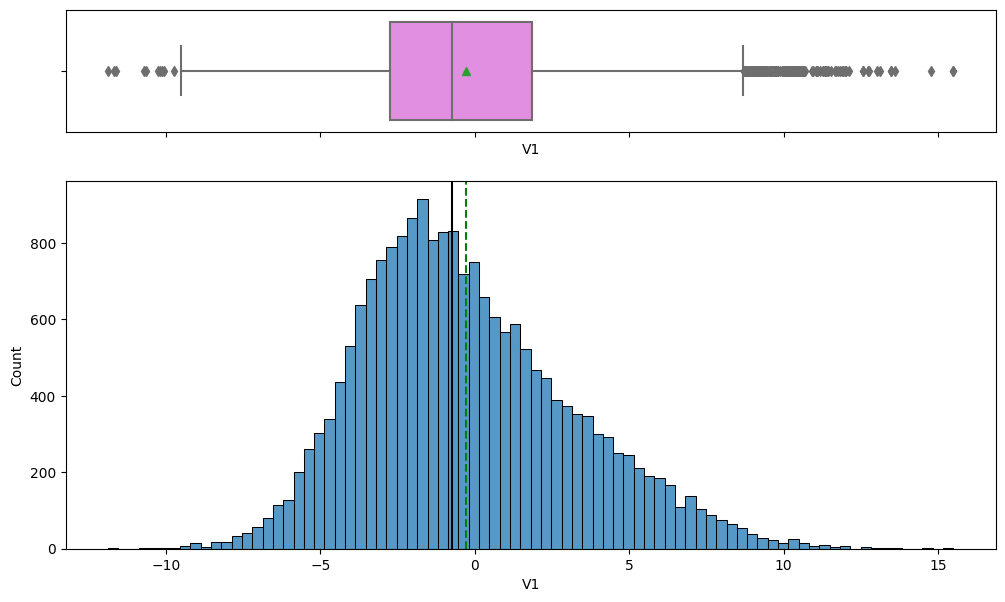

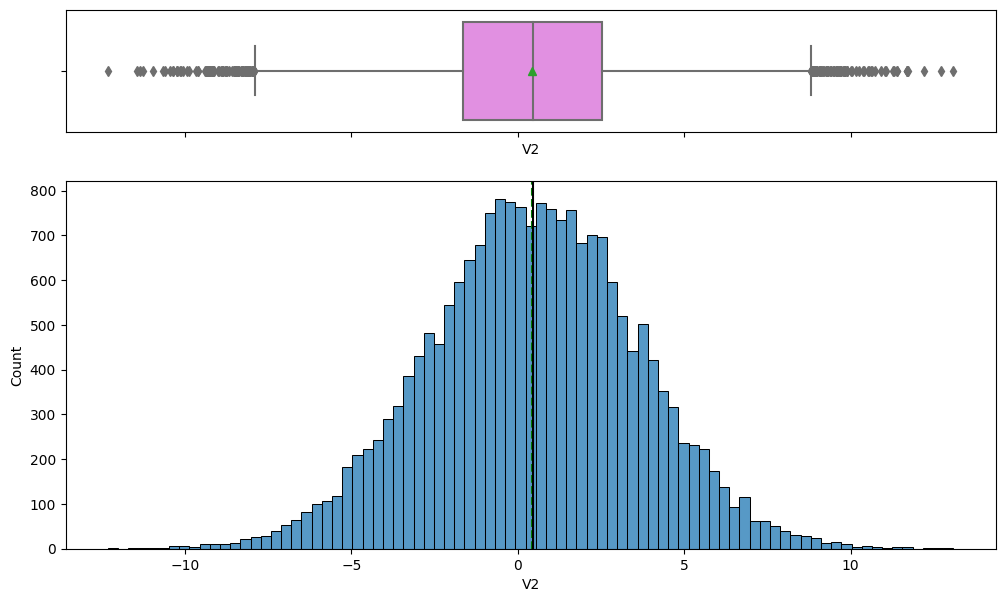

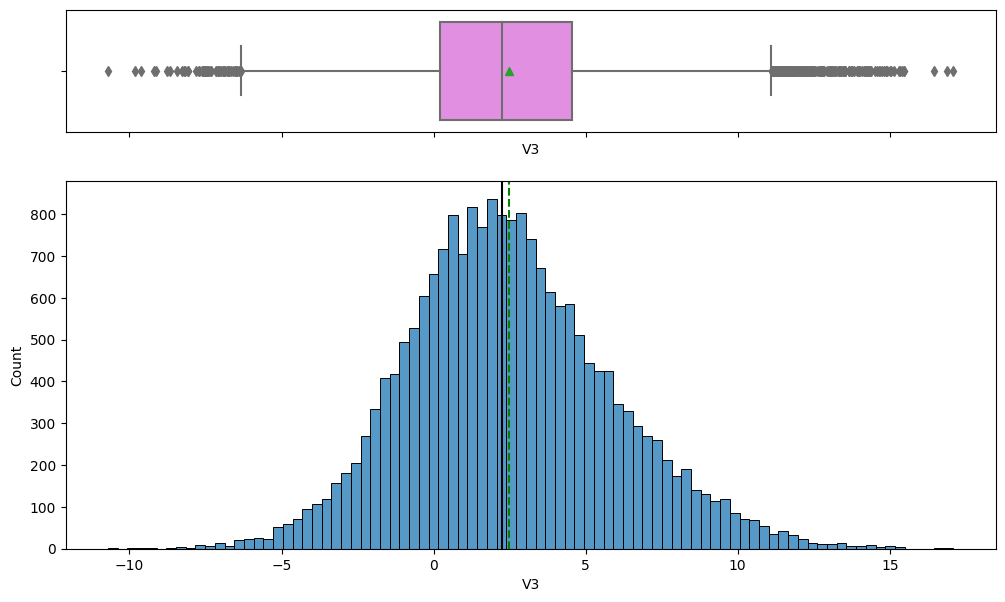

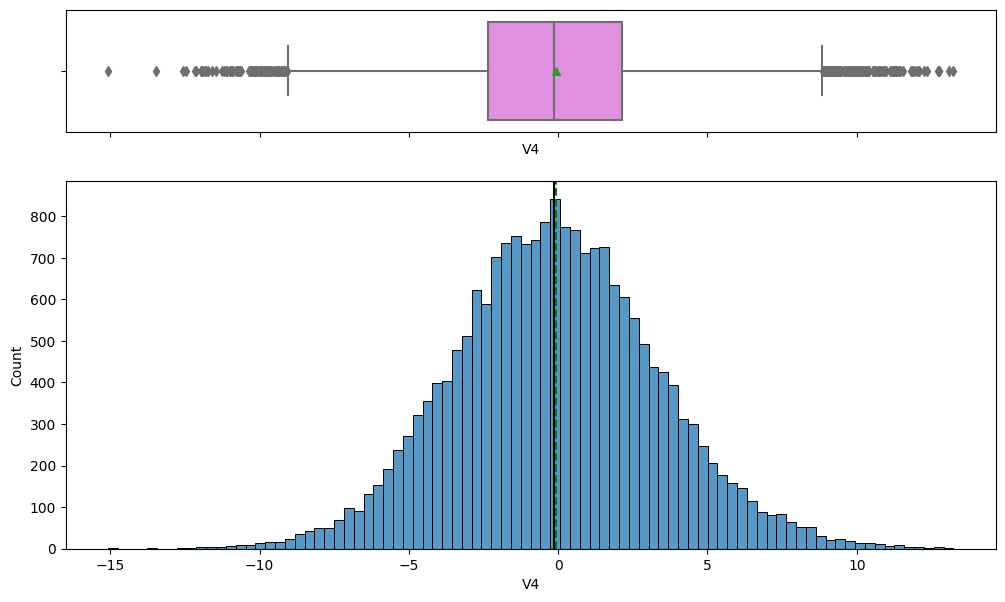

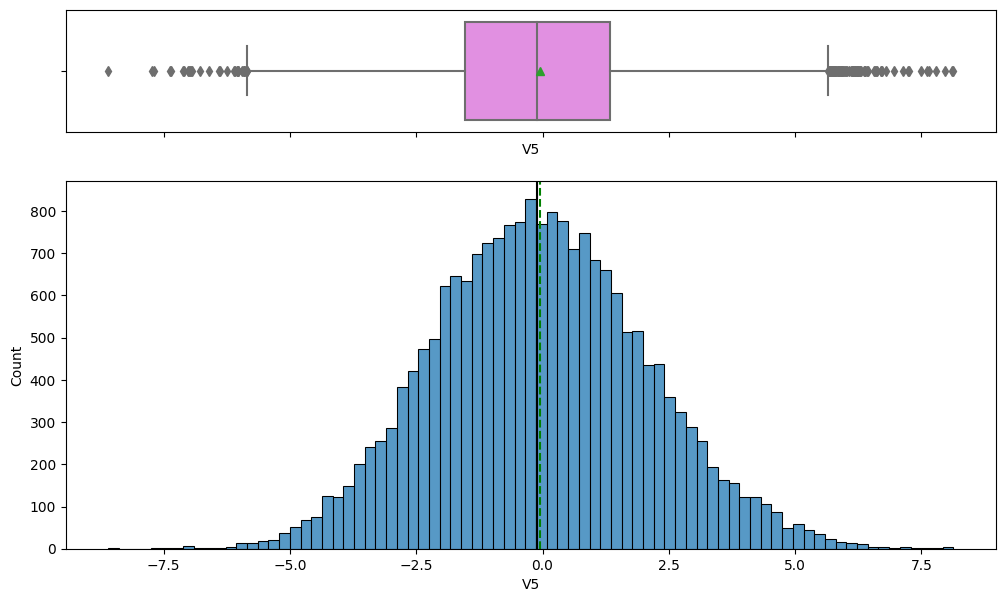

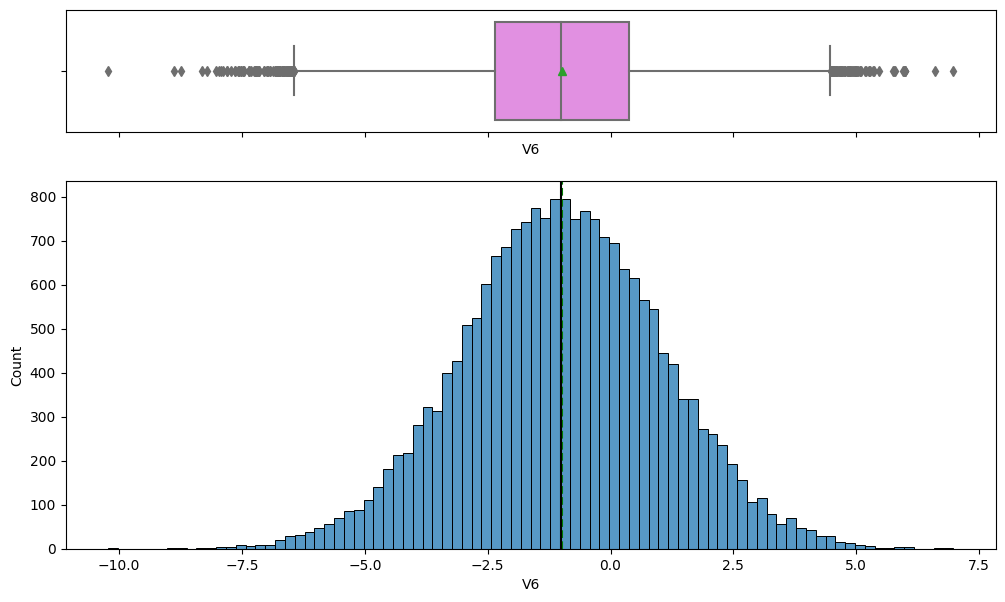

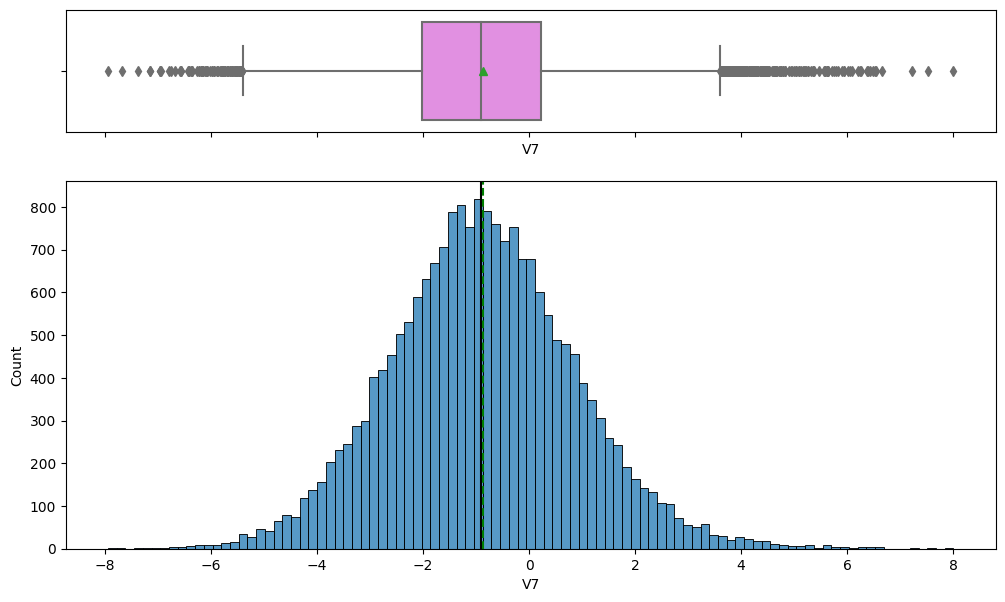

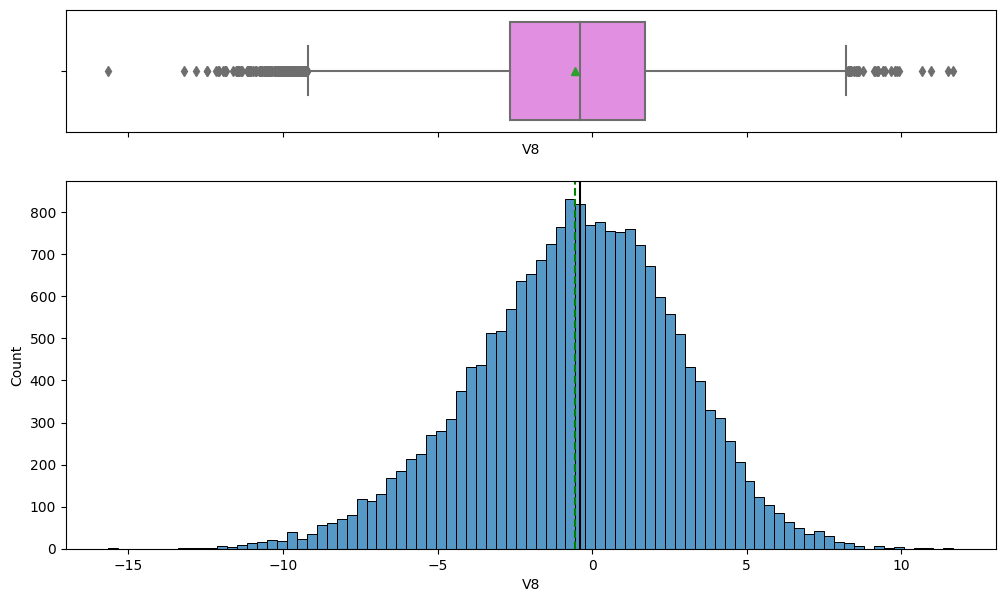

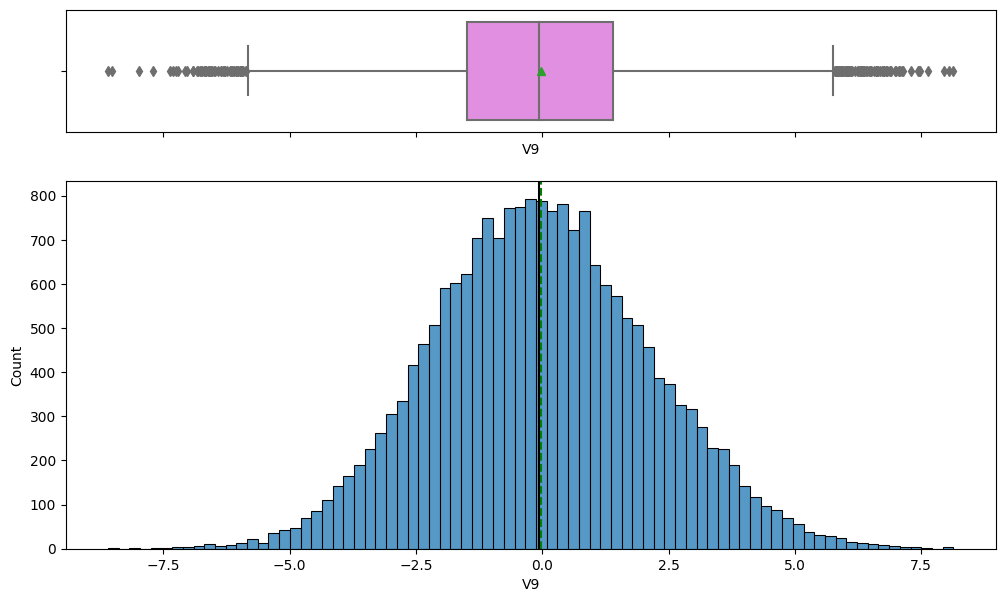

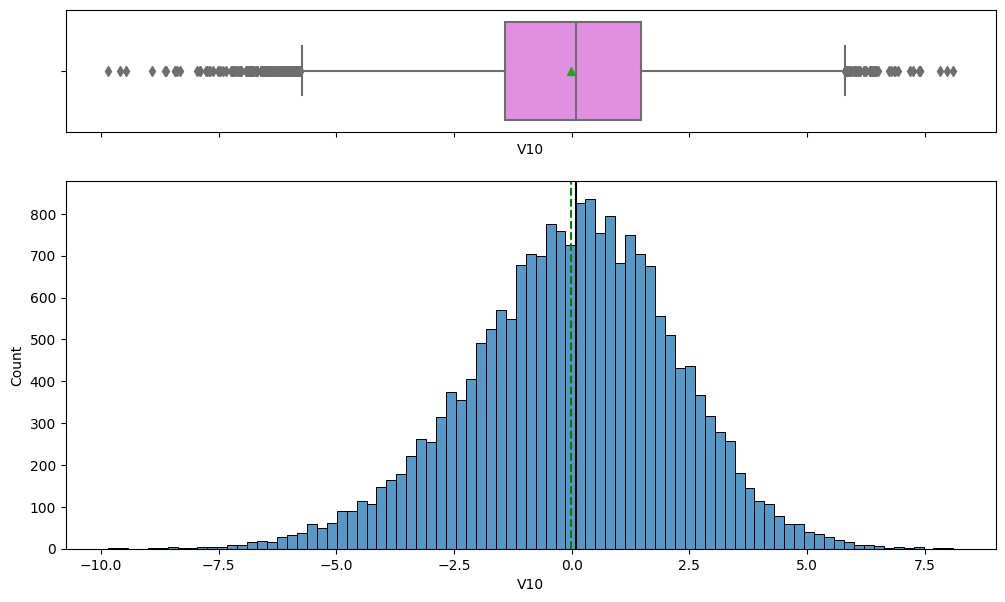

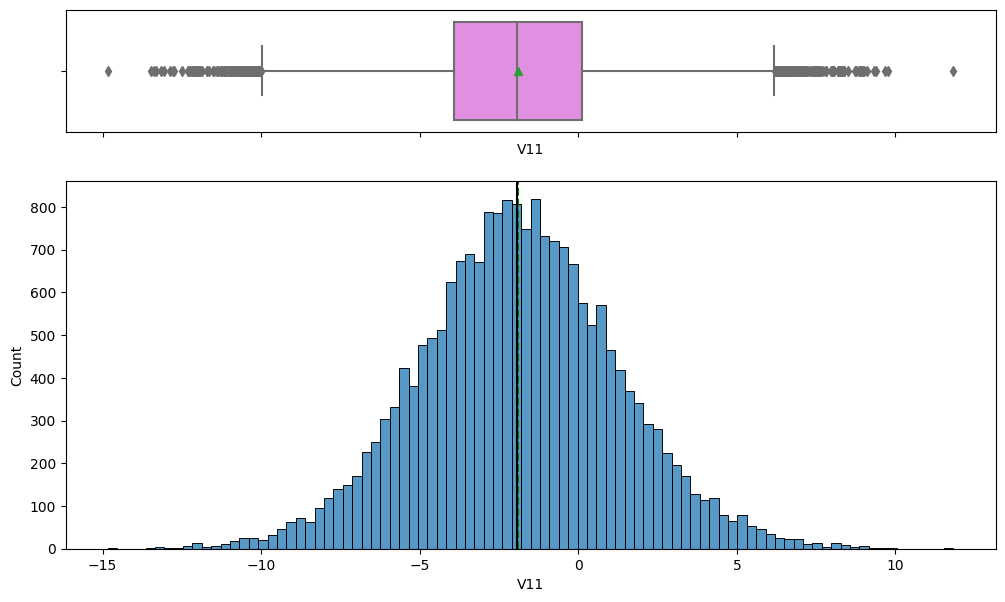

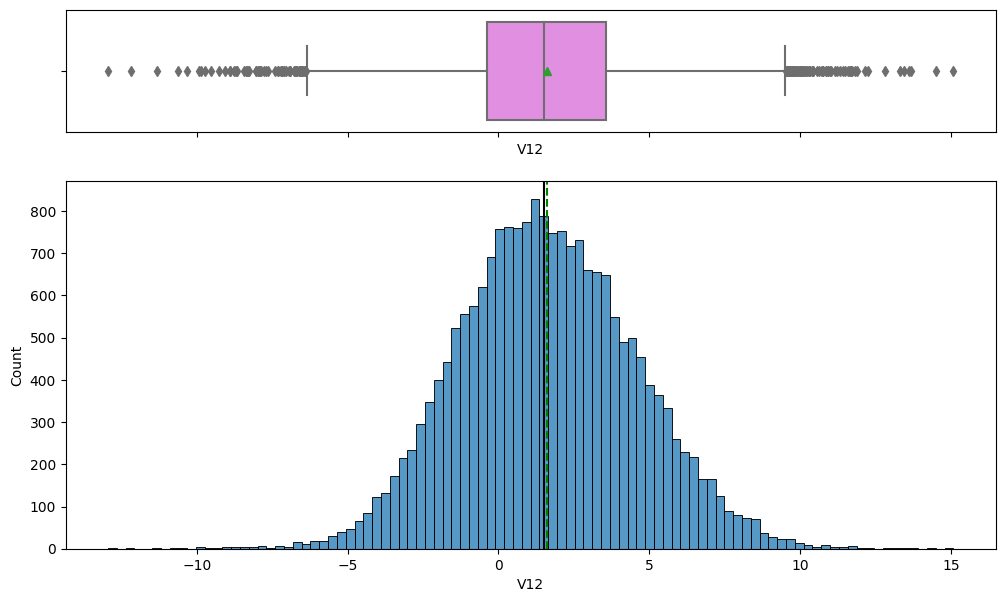

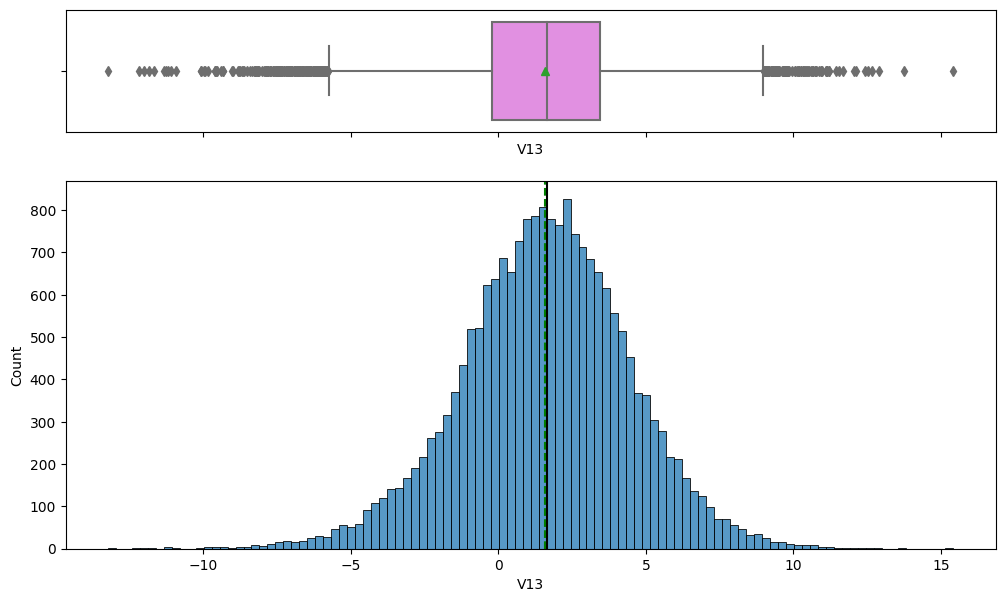

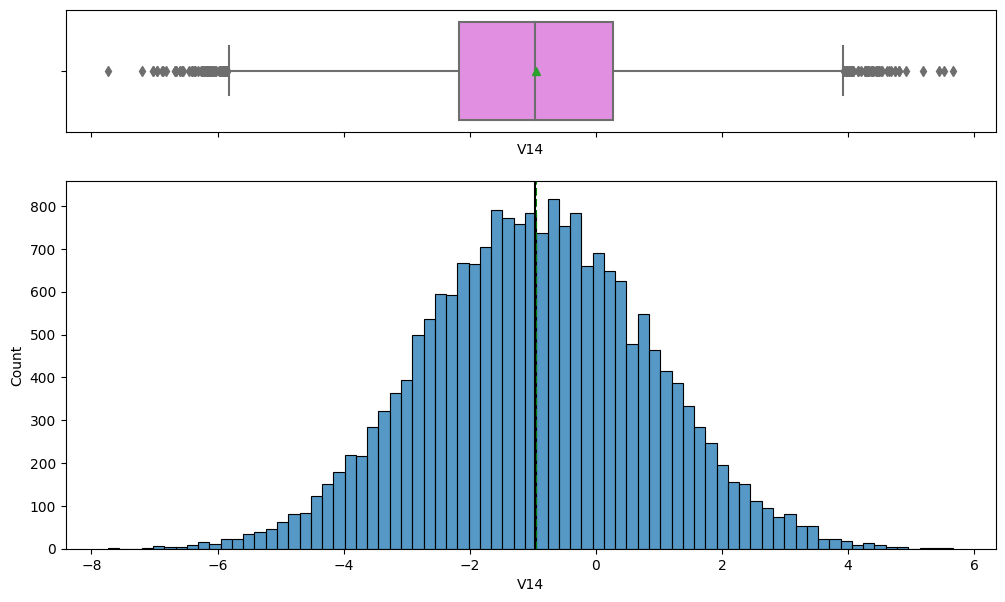

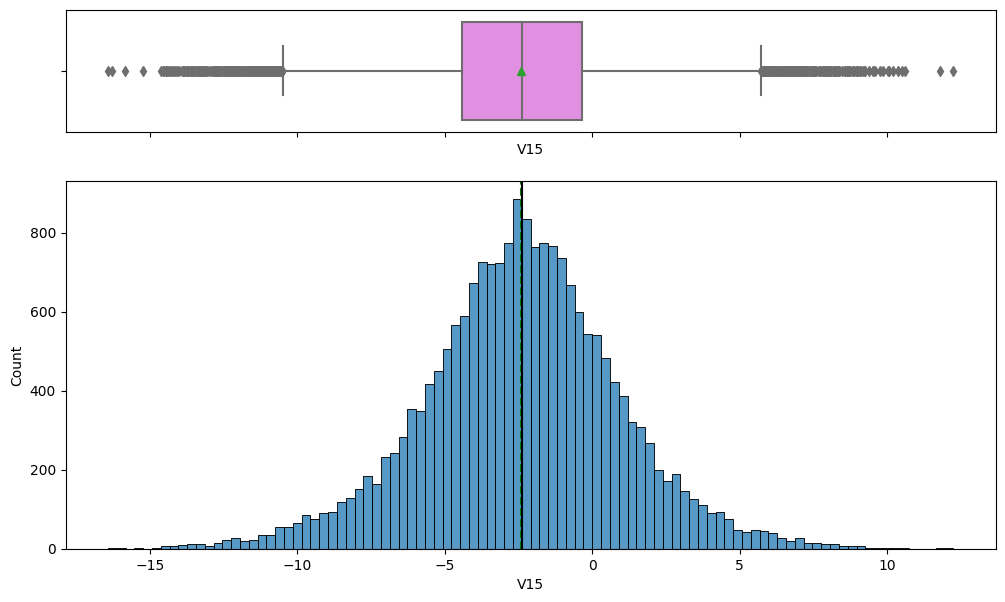

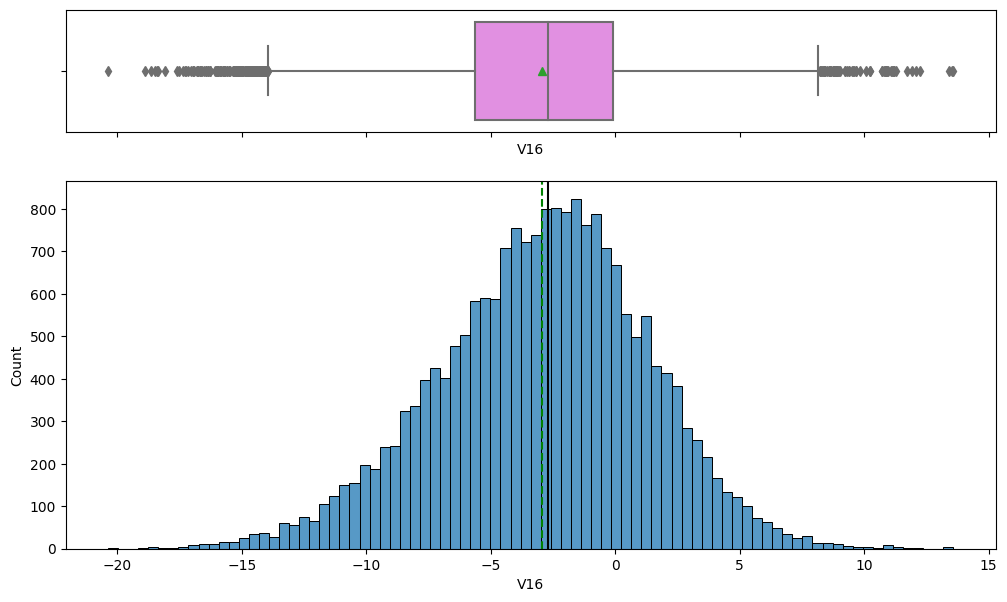

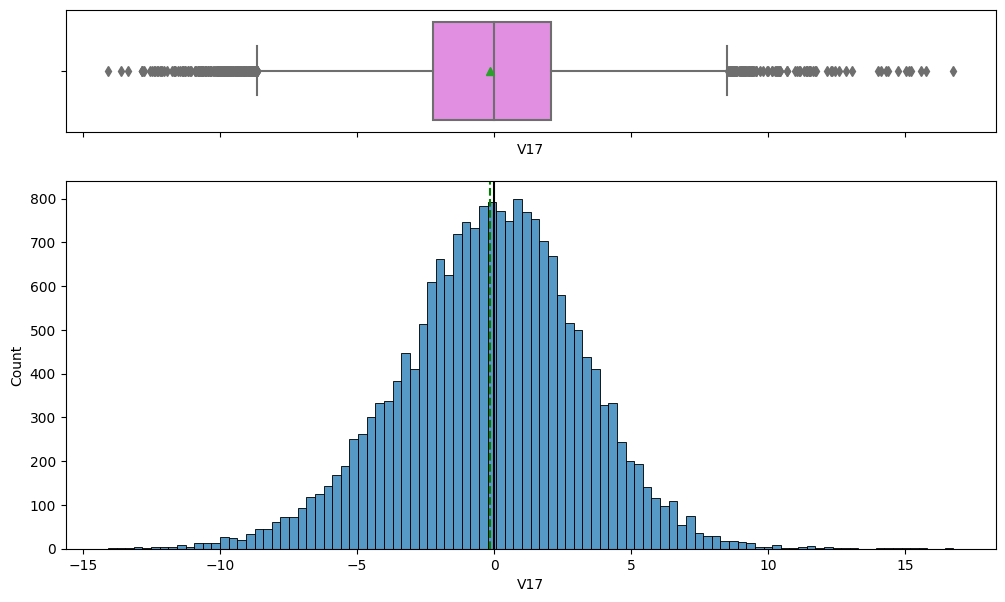

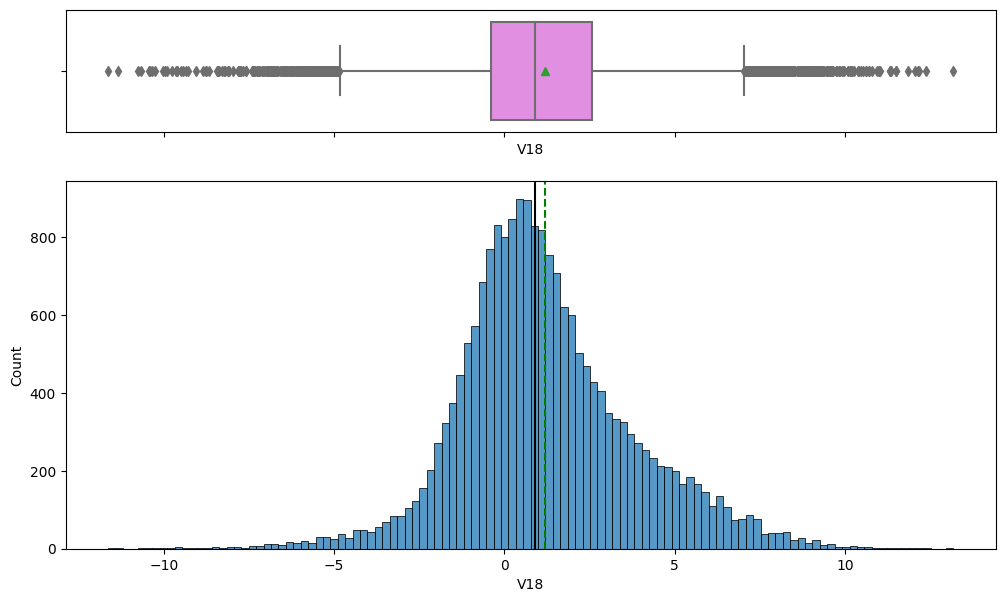

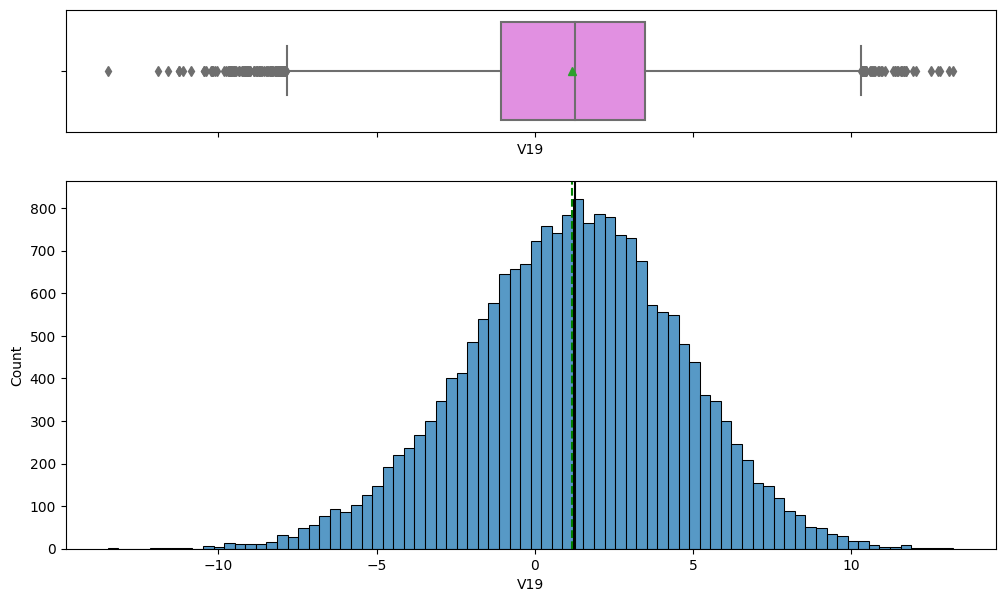

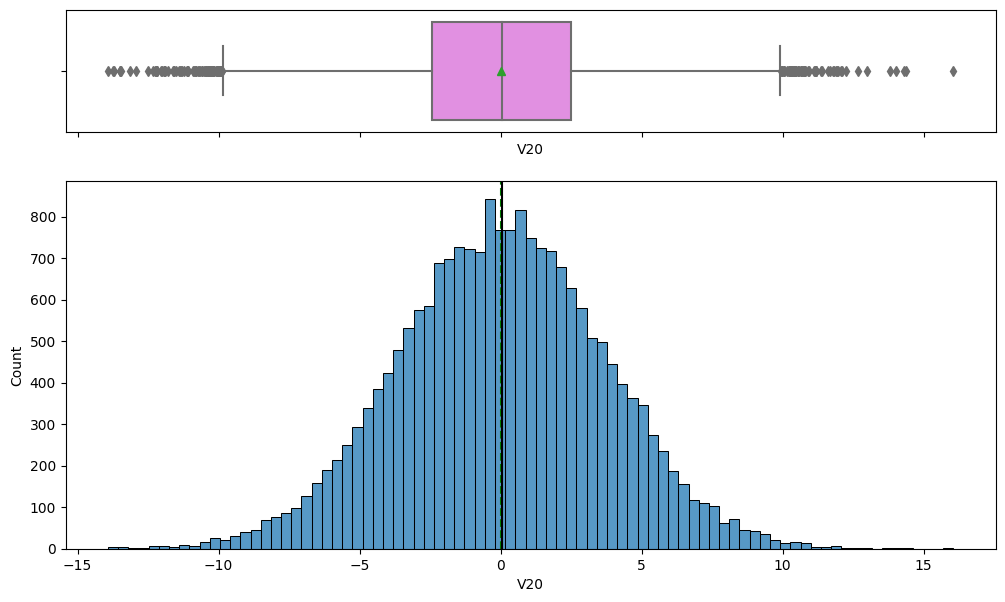

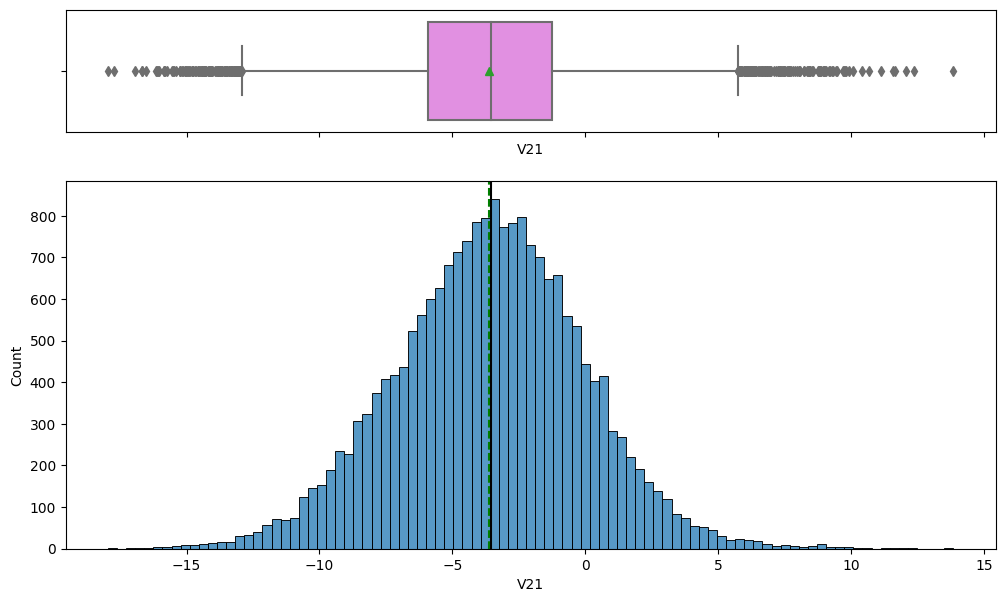

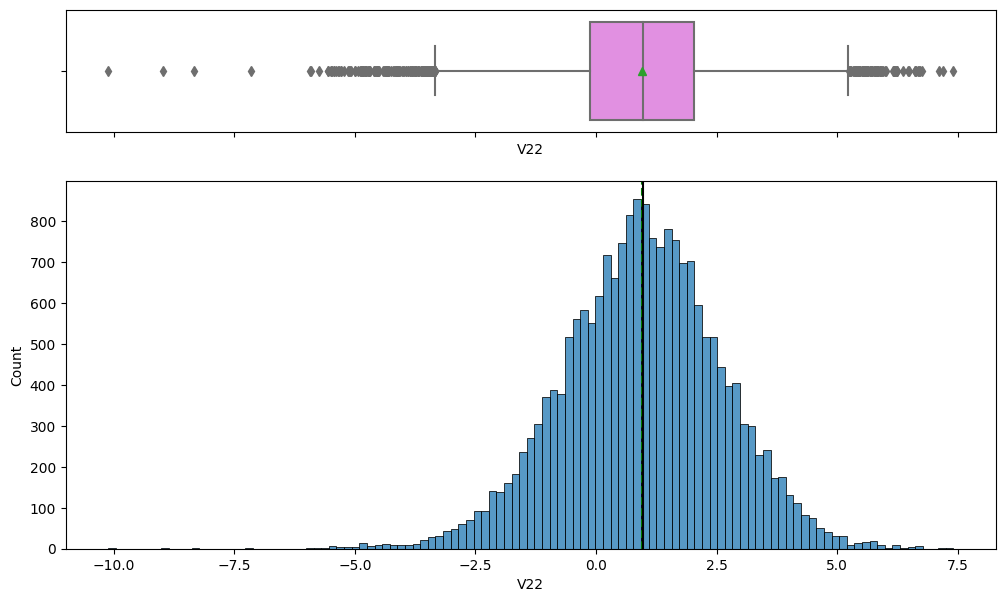

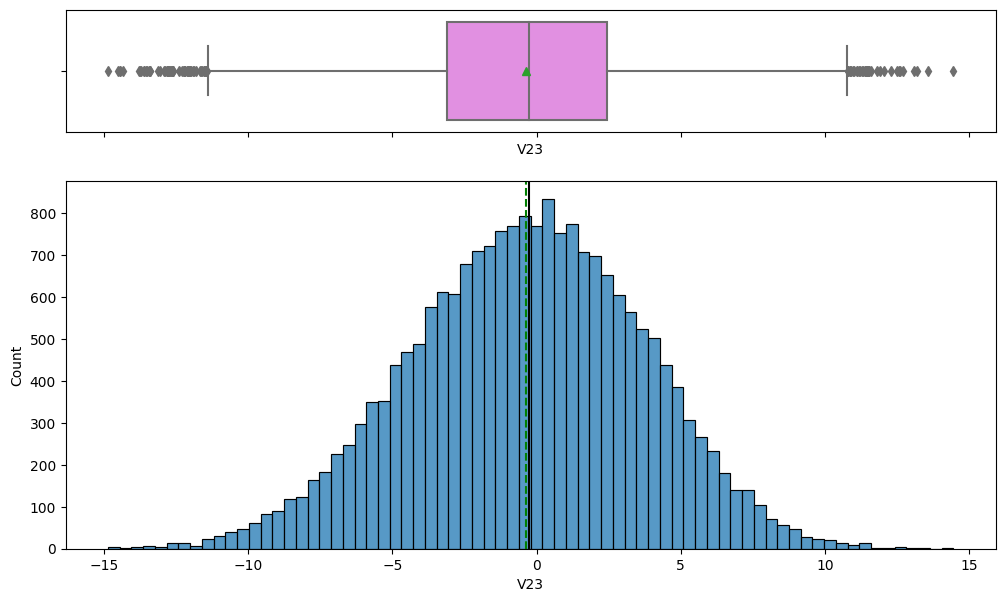

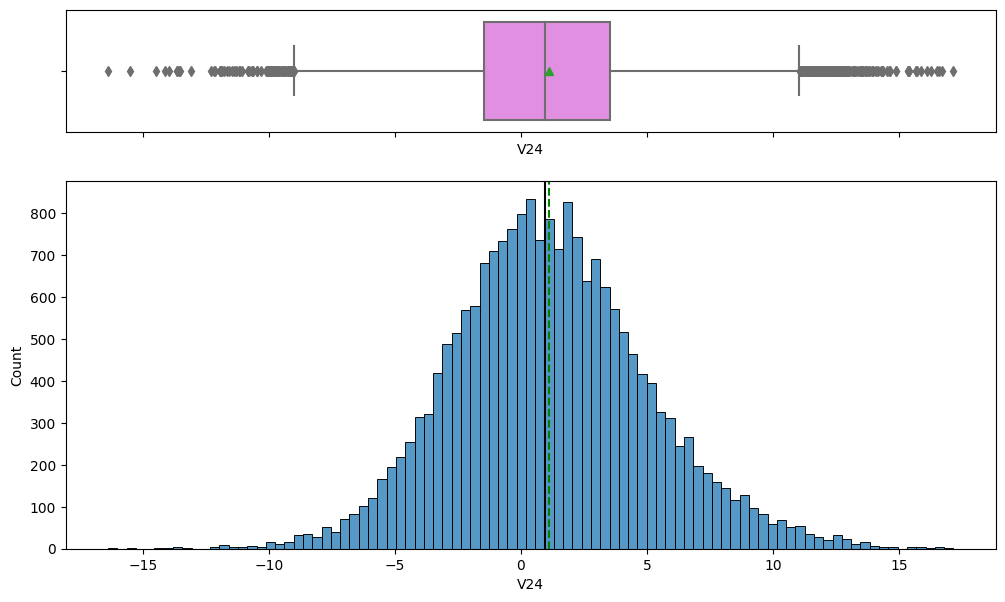

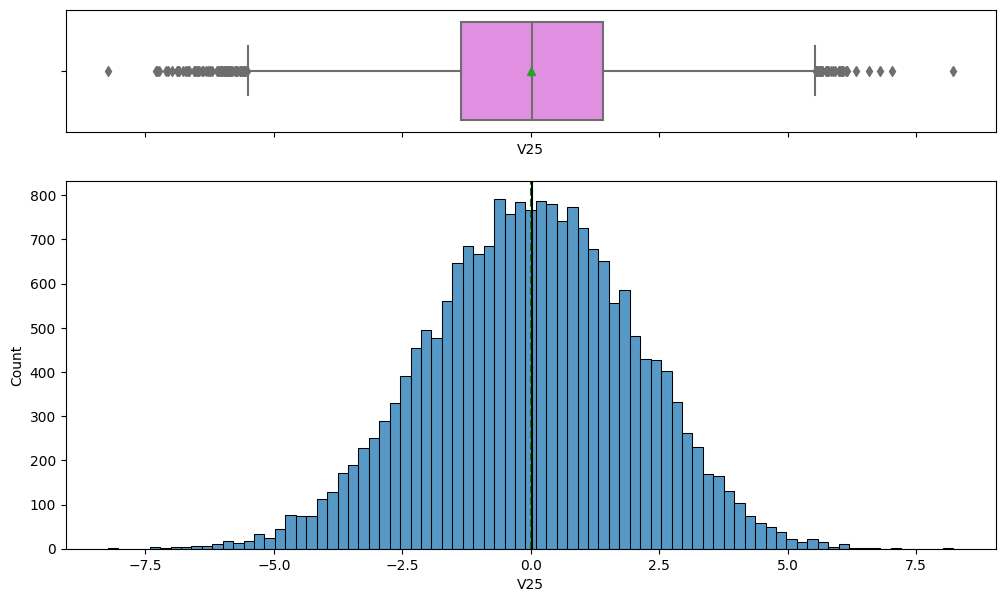

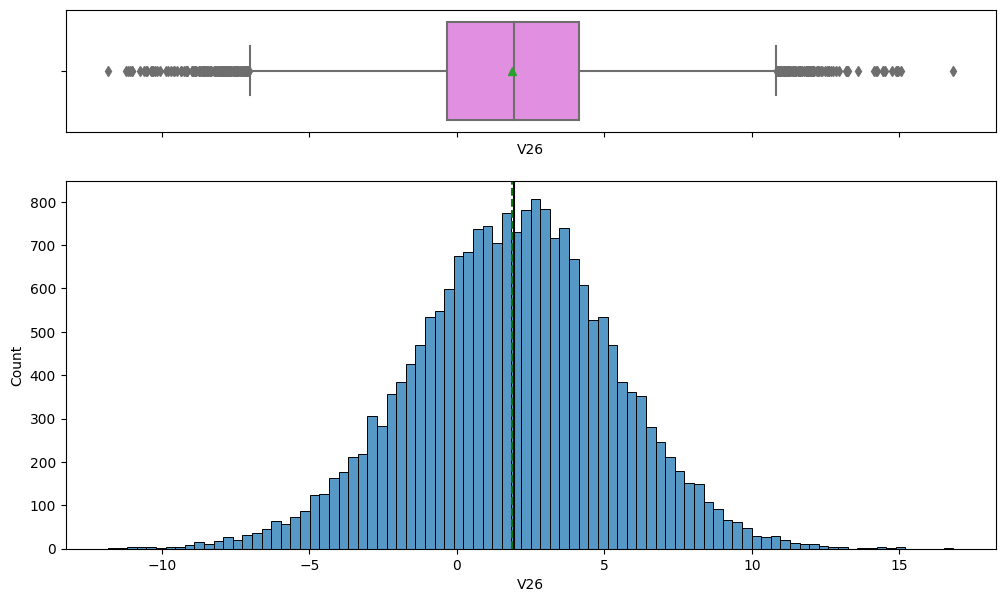

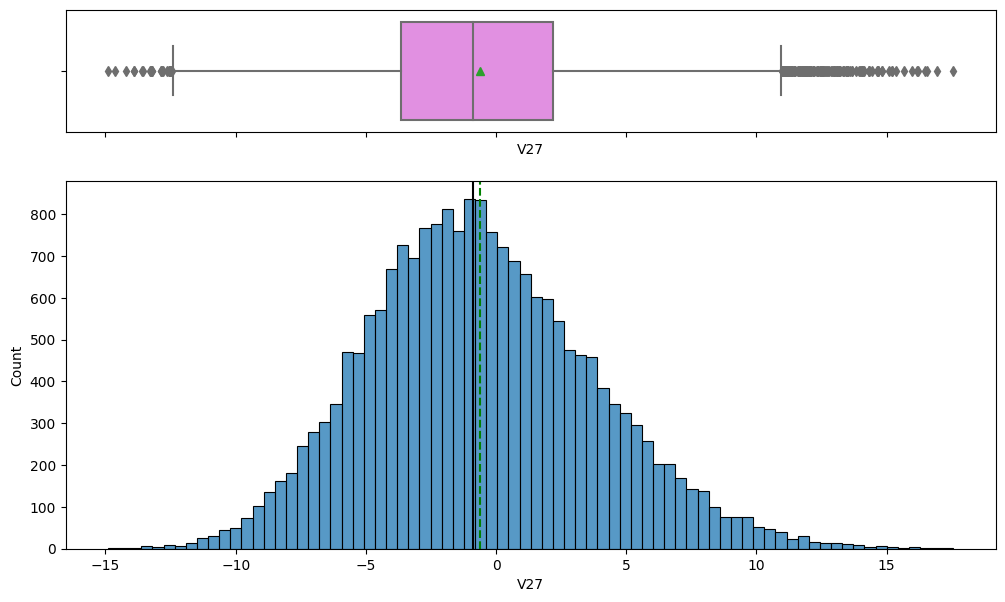

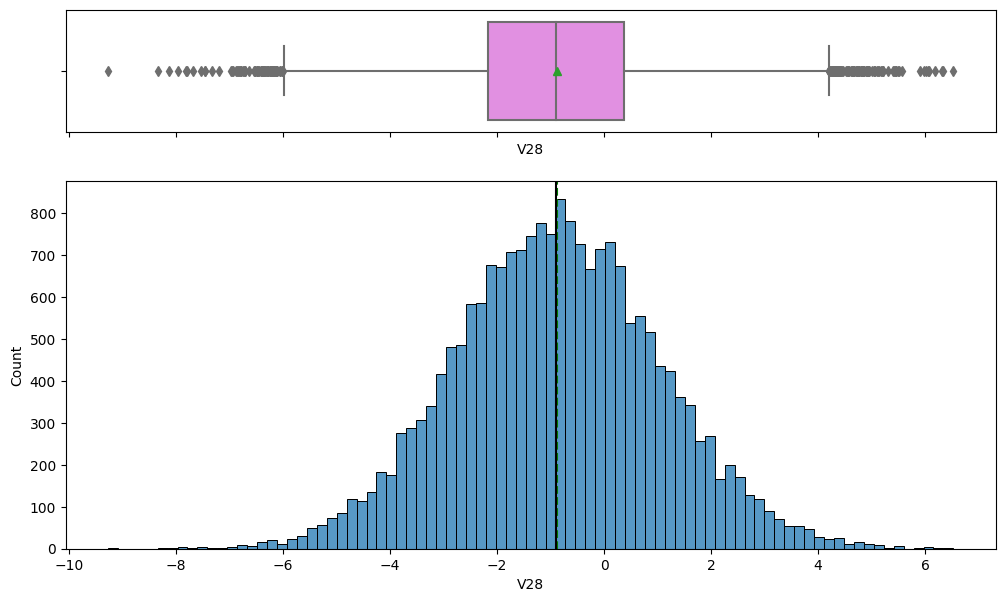

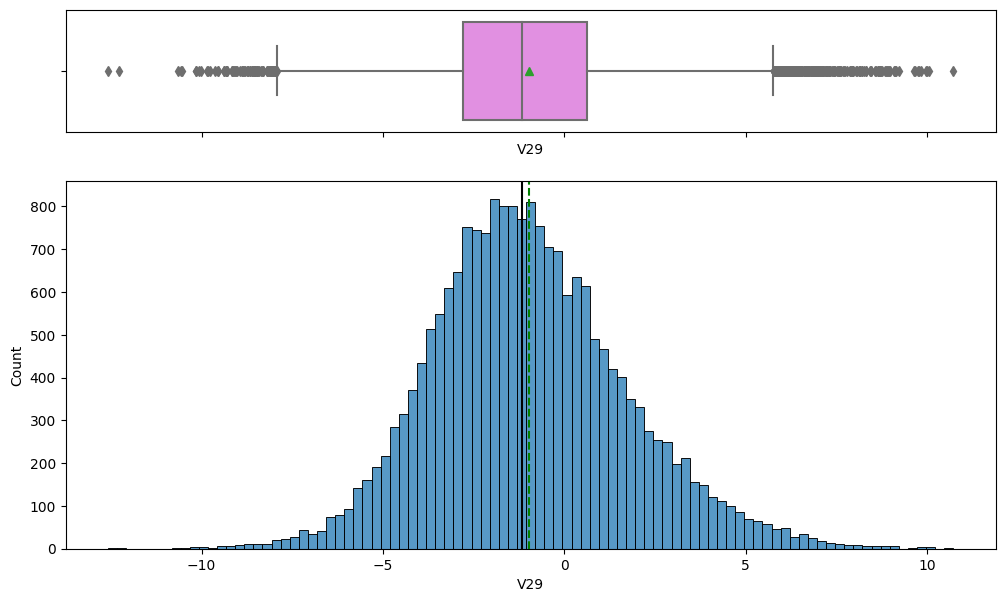

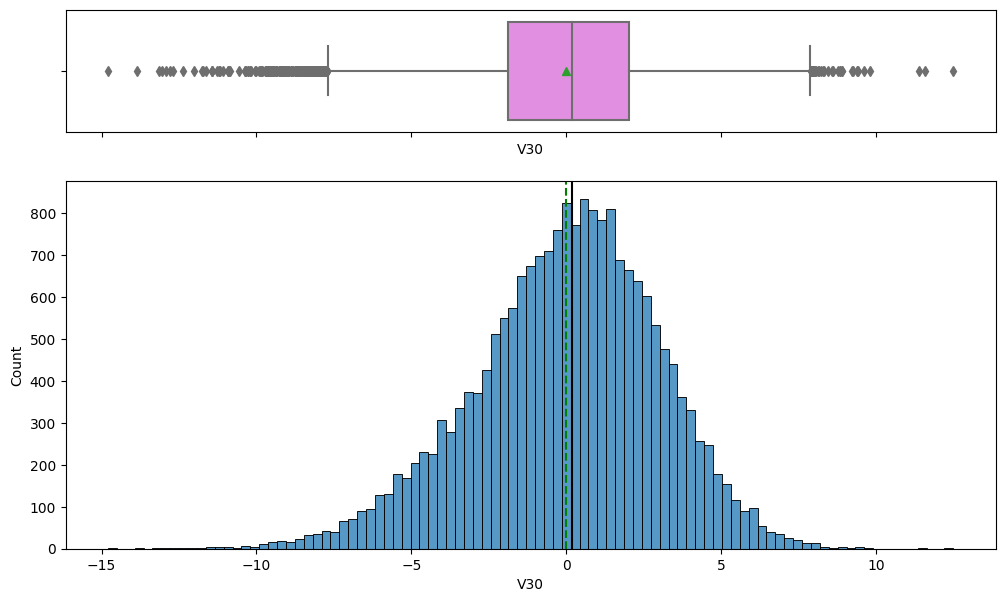

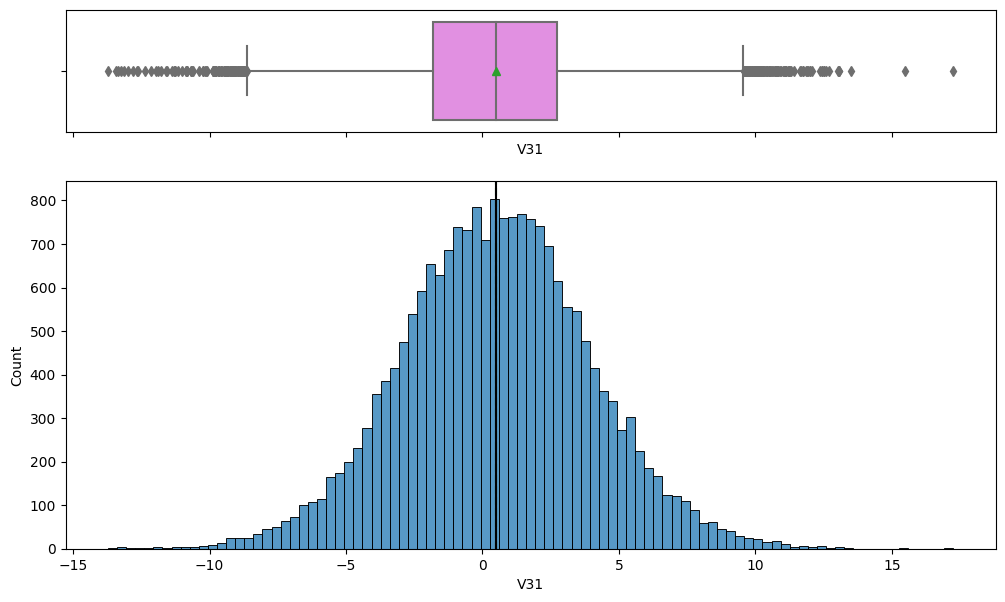

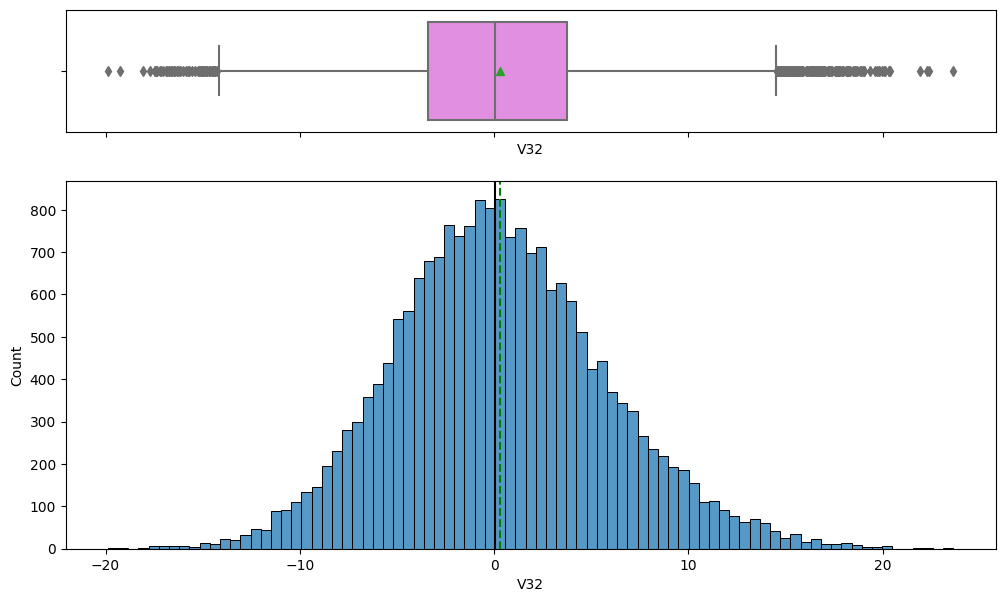

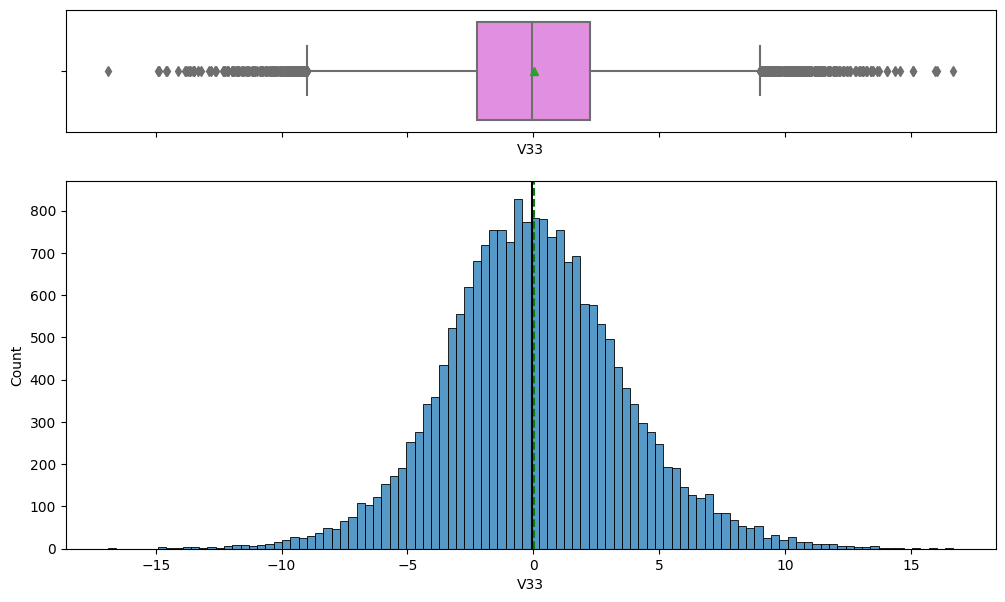

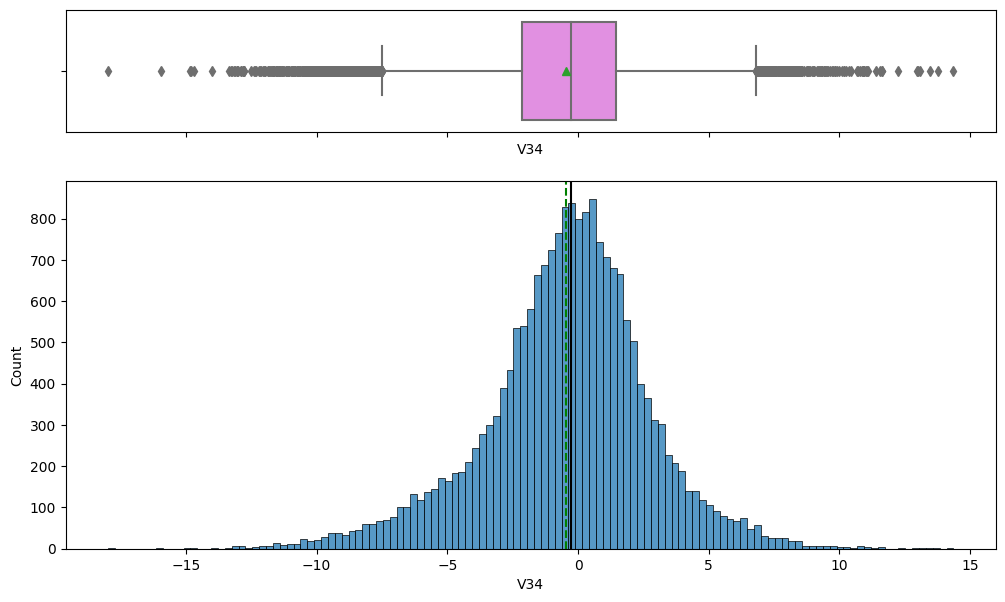

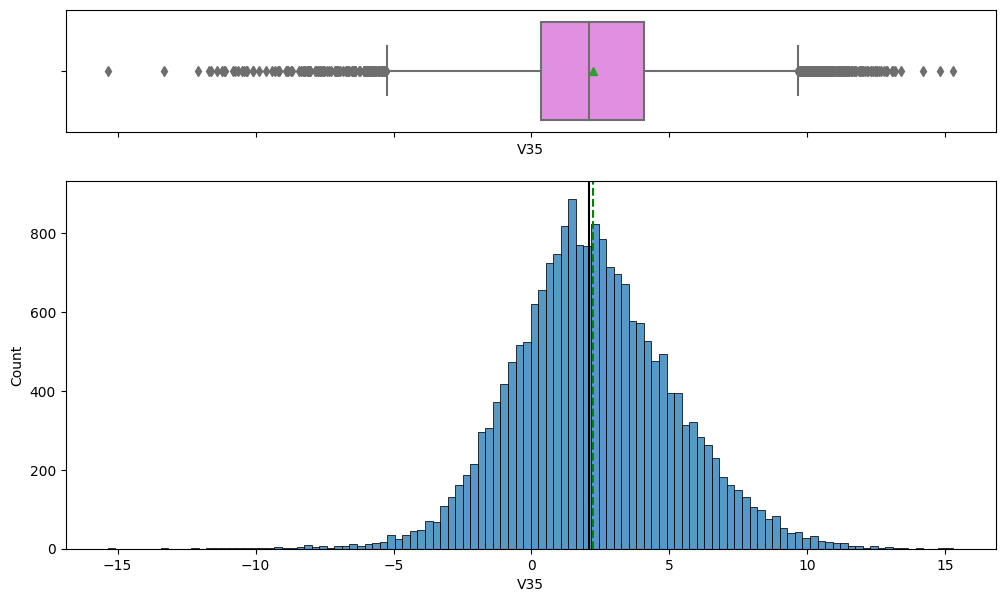

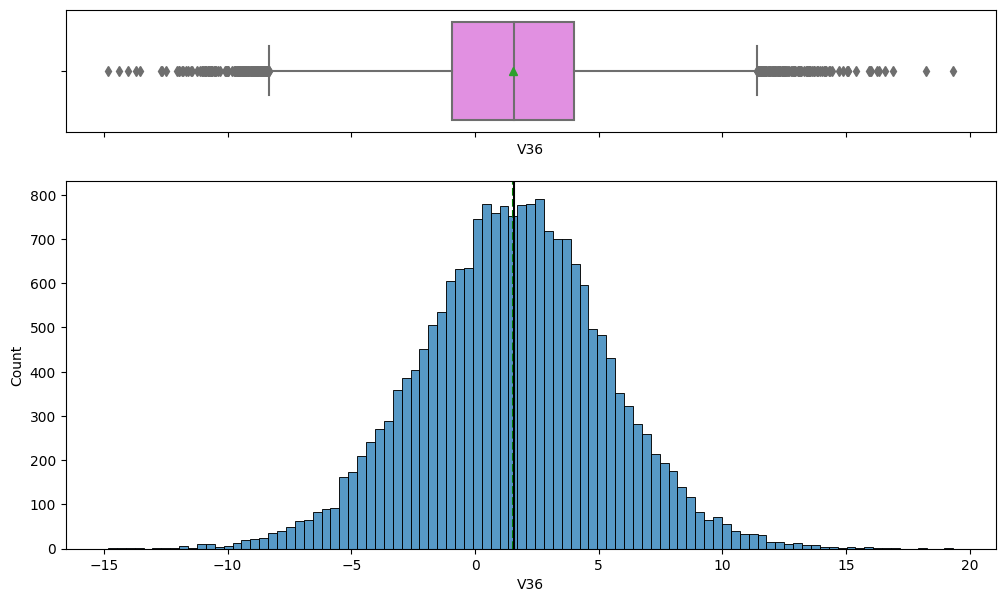

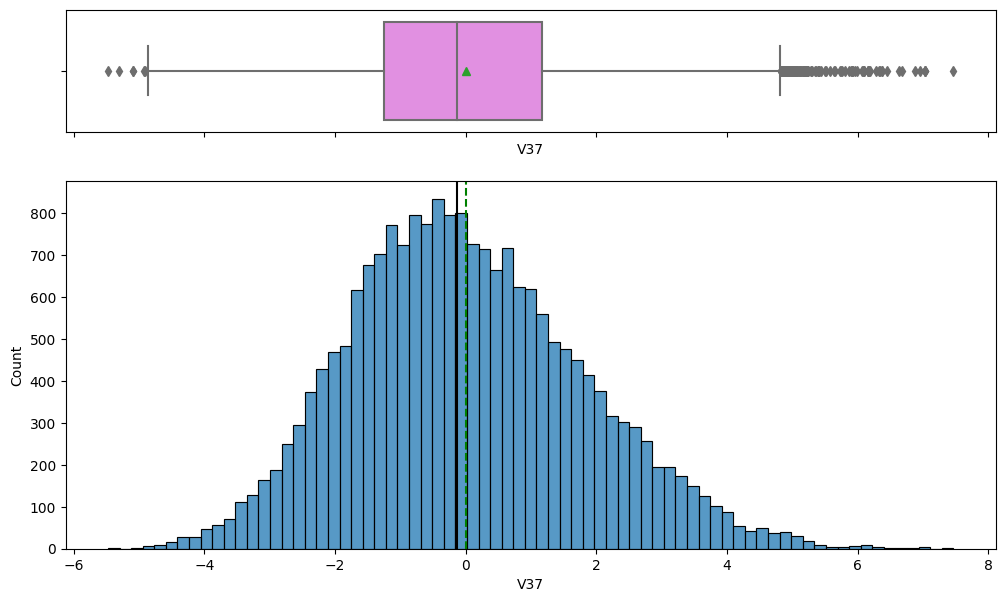

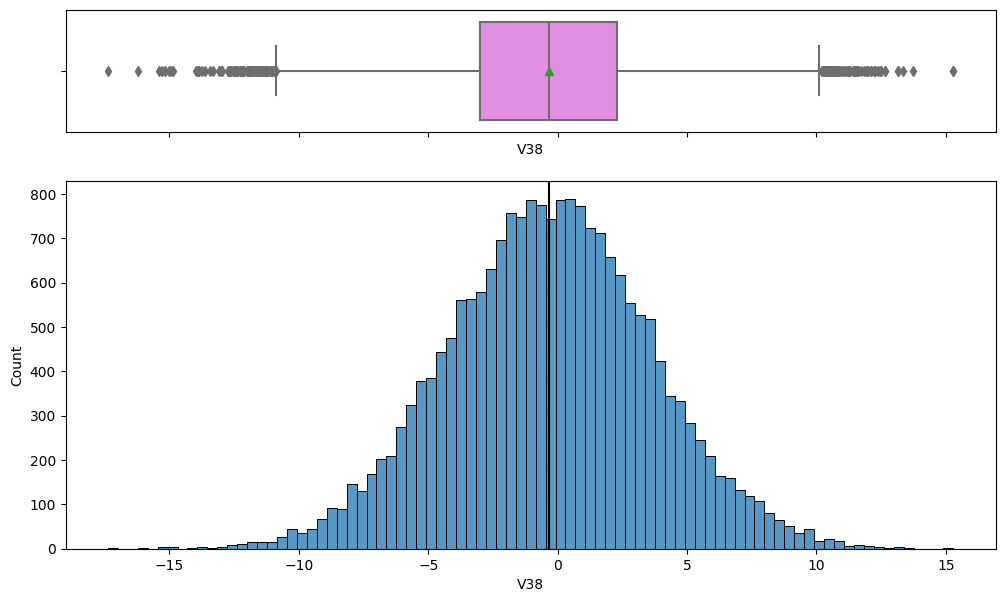

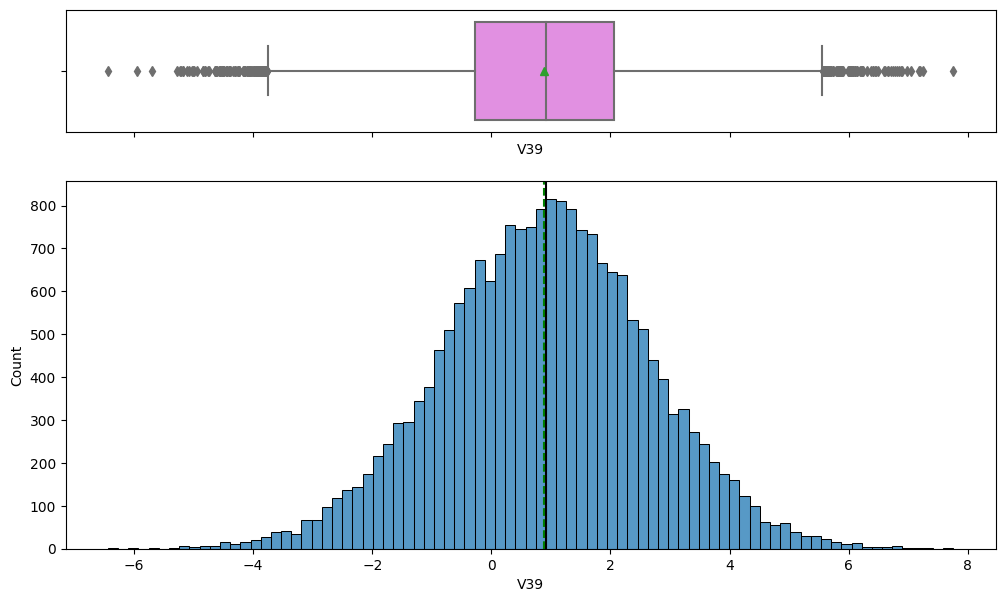

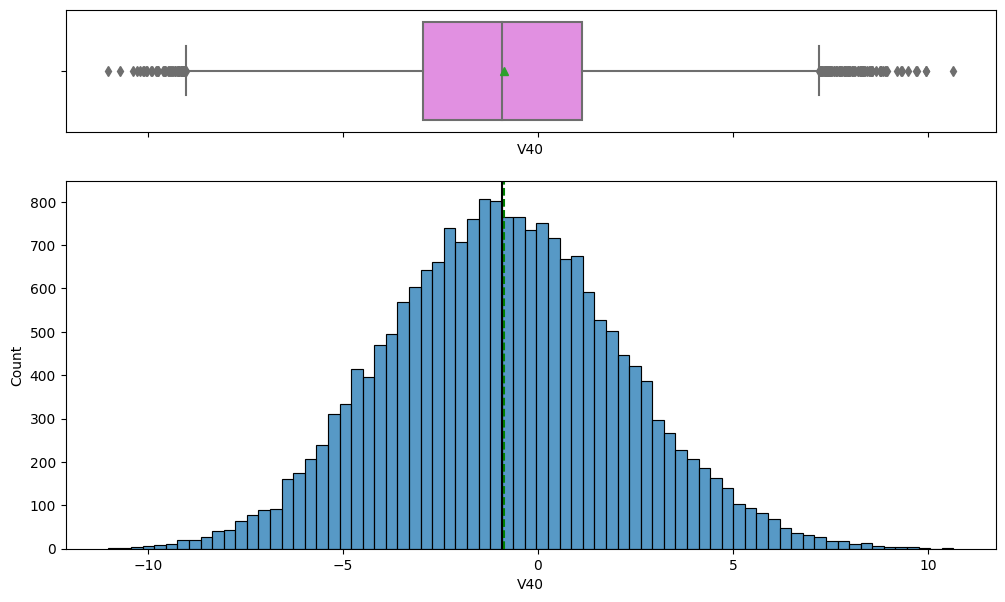

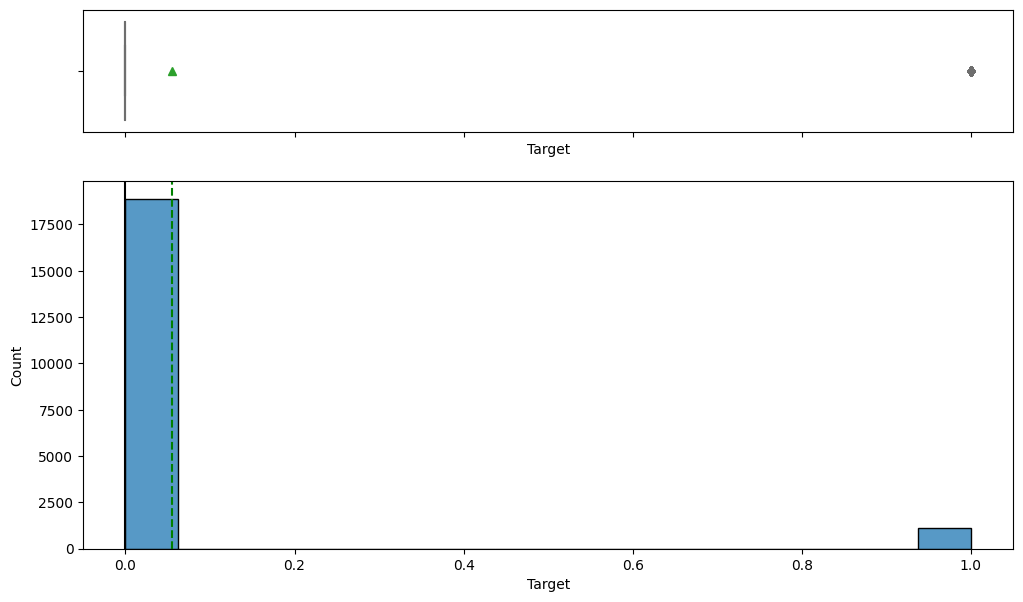

In [ ]:
for feature in df.columns:
  histogram_boxplot(df, feature)

- Variables skewed to the right are (V): 1 and 7(slightly).

- Variables skewed to the left are: 8, 10 (slightly), and 22 (mainly due to outliers).

- Most variables have a similar mean and median.

- Overall most variables follow a distribution that resembles normality; amazing.

- Data is heavily imbalanced. Less than 2.000 engines were identified as failures.

In [ ]:
df['Target'].value_counts(1)

0   0.945
1   0.056
Name: Target, dtype: float64

In [ ]:
df_test['Target'].value_counts(1)

0   0.944
1   0.056
Name: Target, dtype: float64

- On both sets, failures are only 5.6%. Data is very imbalanced and will probably benefit from balancing techniques.

## Data Pre-processing

### Train & Validation Split

Since we already have a test set, we'll only separate the training data into training and validation.

In [ ]:
# X and Y
X = df.drop(['Target'], axis=1)
y = df['Target']

# Train & Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

# Print the splits to make sure they're ok
print("Shape of Training set : ", X_train.shape)
print("Shape of validation set : ", X_val.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_val.value_counts(normalize=True))

Shape of Training set :  (15000, 40)
Shape of validation set :  (5000, 40)
Percentage of classes in training set:
0   0.945
1   0.055
Name: Target, dtype: float64
Percentage of classes in test set:
0   0.944
1   0.056
Name: Target, dtype: float64


- We kept the balance on the test classes, and split the data correctly in 75:25

### Test Split

In [ ]:
# Now let's split the test df
X_test = df_test.drop('Target', axis=1)
y_test = df_test['Target']

In [ ]:
print("Shape of X_test set : ", X_test.shape)
print("Shape of y_test set : ", y_test.shape)
print(y_test.value_counts(normalize=True))

Shape of X_test set :  (5000, 40)
Shape of y_test set :  (5000,)
0   0.944
1   0.056
Name: Target, dtype: float64


## Missing value imputation




In [ ]:
# creating an instace of the imputer using the median
imputer = SimpleImputer(strategy="median")

In [ ]:
# Fit and transform the X train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the X validation data
X_val = pd.DataFrame(imputer.fit_transform(X_val), columns=X_train.columns)

# Transform the X test data
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_train.columns)

In [ ]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print(X_val.isna().sum())
print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V2

- There are no missing values in the training splits

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

### Performance function

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [ ]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

We'll use the original data to train 6 different classification models; logistic regression, decision tree, bagging classifier, random forest, adaboost classifier, and gradient boosting classifier.

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list

models.append(('log_regression', LogisticRegression(random_state=1)))
models.append(("decision_tree", DecisionTreeClassifier(random_state=1)))
models.append(('bagging', BaggingClassifier(random_state=1)))
models.append(('random_forest', RandomForestClassifier(random_state=1)))
models.append(('ada_boost', AdaBoostClassifier(random_state=1)))
models.append(('gradient_boosting', GradientBoostingClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

log_regression: 0.46888655970329757
decision_tree: 0.7071353704748852
bagging: 0.7235830041119085
random_forest: 0.709658953478997
ada_boost: 0.6285817947270822
gradient_boosting: 0.7261791502055954

Validation Performance:

log_regression: 0.5285171102661597
decision_tree: 0.688212927756654
bagging: 0.7186311787072244
random_forest: 0.7262357414448669
ada_boost: 0.5931558935361216
gradient_boosting: 0.7300380228136882


- The best models are decision tree, bagging, random_forest, and gradient boosting. The last 2 had a validation score higher than training.

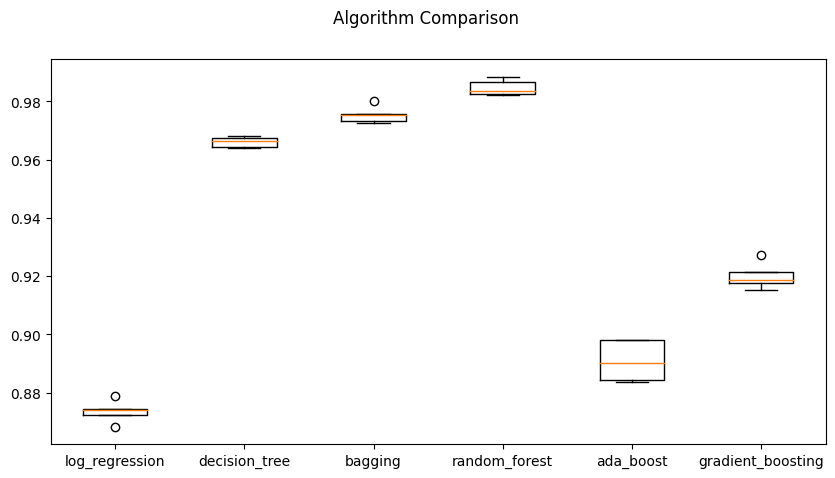

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 5))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

- Based on the distributions, recall seems to peak at ~0.78. None of the models got a higher score.
- bagging and random_forest models have the lowest recall variance.
- log_regression has the worst performance overall with the recall score ranging between 0.40 and 0.55.

### Model Building with Oversampled data


In [ ]:
print("Before OverSampling, counts of Failures: {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of Non-Failures: {} \n".format(sum(y_train == 0)))

# Let's oversample using the Synthetic Minority Over Sampling Technique

sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

# Now let's see how the balance changed
print("After OverSampling, counts of Failures: {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of Non-Failures: {} \n".format(sum(y_train_over == 0)))

print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of Failures: 789
Before OverSampling, counts of Non-Failures: 13403 

After OverSampling, counts of Failures: 13403
After OverSampling, counts of Non-Failures: 13403 

After OverSampling, the shape of train_X: (26806, 40)
After OverSampling, the shape of train_y: (26806,) 



- Now there's an equal number of failures and non-failures, and the overall sample size increased to 26.806.

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list

models.append(('log_regression', LogisticRegression(random_state=1)))
models.append(("decision_tree", DecisionTreeClassifier(random_state=1)))
models.append(('bagging', BaggingClassifier(random_state=1)))
models.append(('random_forest', RandomForestClassifier(random_state=1)))
models.append(('ada_boost', AdaBoostClassifier(random_state=1)))
models.append(('gradient_boosting', GradientBoostingClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

log_regression: 0.8735357435129462
decision_tree: 0.9659779153468019
bagging: 0.9753790354456735
random_forest: 0.984630289433103
ada_boost: 0.8909199340856329
gradient_boosting: 0.9200176198455688

Validation Performance:

log_regression: 0.8745247148288974
decision_tree: 0.7984790874524715
bagging: 0.8212927756653993
random_forest: 0.8669201520912547
ada_boost: 0.8631178707224335
gradient_boosting: 0.8859315589353612


- Performance increased among all models.
- decision_tree, bagging, and random_forest have great performance, but suffer from overfitting.
- log_regression, and gradient_boosting are the most consistent and have very good recall scores.

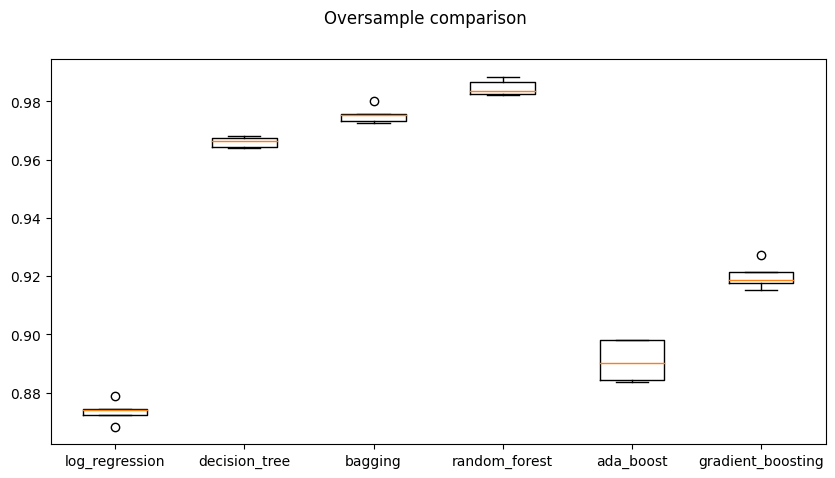

In [ ]:
fig = plt.figure(figsize=(10, 5))

fig.suptitle("Oversample comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

- Overall, recall variance decreased compared to models trained on the original data.
- random_forest has the best scores, followed by bagging and decision_tree.

### Model Building with Undersampled data

In [ ]:
# For the undersample, we'll use the Random undersampler

rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

print("Before UnderSampling, counts of Failures: {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of No Failures: {} \n".format(sum(y_train == 0)))

print("After UnderSampling, counts of Failures: {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of No Failures': {} \n".format(sum(y_train_un == 0)))

print("After UnderSampling, the shape of Failures: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of No Failures: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of Failures: 789
Before UnderSampling, counts of No Failures: 13403 

After UnderSampling, counts of Failures: 789
After UnderSampling, counts of No Failures': 789 

After UnderSampling, the shape of Failures: (1578, 40)
After UnderSampling, the shape of No Failures: (1578,) 



- We matched the number of No Failures and Failures at 789. New sample size is 1.578.

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list

models.append(('log_regression', LogisticRegression(random_state=1)))
models.append(("decision_tree", DecisionTreeClassifier(random_state=1)))
models.append(('bagging', BaggingClassifier(random_state=1)))
models.append(('random_forest', RandomForestClassifier(random_state=1)))
models.append(('ada_boost', AdaBoostClassifier(random_state=1)))
models.append(('gradient_boosting', GradientBoostingClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

log_regression: 0.8453761186809643
decision_tree: 0.8326372651777796
bagging: 0.8580343465290655
random_forest: 0.8922679996774974
ada_boost: 0.8643634604531162
gradient_boosting: 0.8833830524873015

Validation Performance:

log_regression: 0.8783269961977186
decision_tree: 0.8517110266159695
bagging: 0.8745247148288974
random_forest: 0.8973384030418251
ada_boost: 0.8859315589353612
gradient_boosting: 0.8859315589353612


- All the models had a better performance on the validation set compared to the training set.
- random_forest, ada_boost, and gradient_boosting had the best validation recall scores.

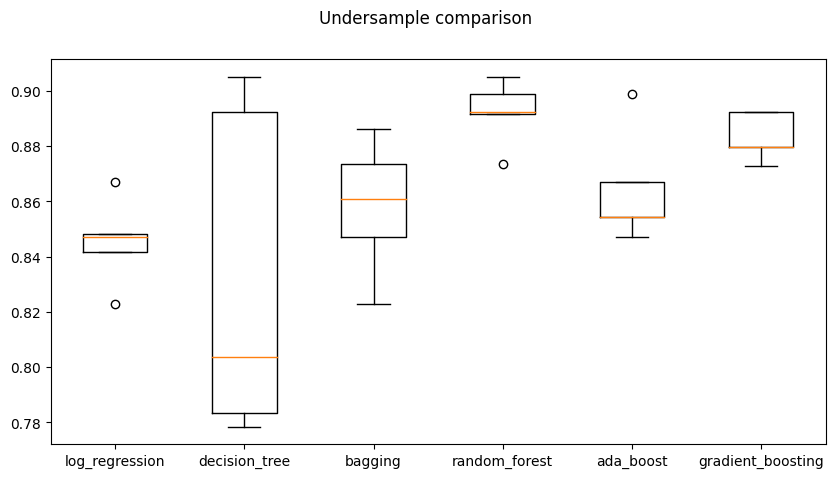

In [ ]:
fig = plt.figure(figsize=(10, 5))

fig.suptitle("Undersample comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

- The decision_tree model has the highest variance.
- random_forest is the best model in terms of variance and overall high scores.

## HyperparameterTuning

Models with oversampled and undersampled data had the best performance overall. Among all of them, these 4 stood up:

Oversampled data:
- ada_boost
- gradient_boosting

Undersampled data:
- random_forest
- gradient_boosting

We'll use hyperparameter tuning to try to improve their performance even more.

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}


- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}



### AdaBoost with Oversampled data

In [ ]:
%%time

# defining AdaBoost model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.2, 0.05],
    'base_estimator': [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=1, random_state=1),
    ]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=1, random_state=1)} with CV score=0.894650303128149:
CPU times: user 1min 9s, sys: 3.49 s, total: 1min 12s
Wall time: 35min 22s


In [ ]:
# Creating new pipeline with best parameters
ada_tuned = AdaBoostClassifier(
    n_estimators= 200, learning_rate= 0.2, base_estimator= DecisionTreeClassifier(max_depth=1, random_state=1)
)

ada_tuned.fit(X_train_over, y_train_over)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200)

In [ ]:
ada_train_perf = model_performance_classification_sklearn(ada_tuned, X_train_over, y_train_over)
ada_train_perf

,Accuracy,Recall,Precision,F1
0,0.915,0.898,0.930,0.914


In [ ]:
ada_val_perf = model_performance_classification_sklearn(ada_tuned, X_val, y_val)
ada_val_perf

,Accuracy,Recall,Precision,F1
0,0.925,0.875,0.418,0.566


### Gradient Boosting with Oversampled data

In [ ]:
%%time

# defining Gradient Boosting model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9706036119291642:
CPU times: user 40.2 s, sys: 2.85 s, total: 43 s
Wall time: 27min 59s


In [ ]:
# New parameters
gradient_over_tuned = GradientBoostingClassifier(
    max_features=0.5,
    random_state=1,
    learning_rate=1,
    n_estimators=125,
    subsample=0.7,
)

gradient_over_tuned.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=1, subsample=0.7)

In [ ]:
gradient_over_train_perf = model_performance_classification_sklearn(gradient_over_tuned, X_train_over, y_train_over)
gradient_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.991,0.991,0.991,0.991


In [ ]:
gradient_over_val_perf = model_performance_classification_sklearn(gradient_over_tuned, X_val, y_val)
gradient_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.963,0.867,0.621,0.724


### Random Forest with Undersampled data

In [ ]:
%%time

# defining Random Forest model
Model = RandomForestClassifier(random_state=1)

# Parameter grid
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.8922921873740226:
CPU times: user 3.95 s, sys: 288 ms, total: 4.24 s
Wall time: 2min 1s


In [ ]:
# New parameters
rf_tuned = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=1,
    max_features='sqrt',
    max_samples=0.6,
)

rf_tuned.fit(X_train_un, y_train_un)

RandomForestClassifier(max_samples=0.6, n_estimators=200)

In [ ]:
rf_train_perf = model_performance_classification_sklearn(rf_tuned, X_train_un, y_train_un)
rf_train_perf

,Accuracy,Recall,Precision,F1
0,0.991,0.982,1.000,0.991


In [ ]:
rf_val_perf = model_performance_classification_sklearn(rf_tuned, X_val, y_val)
rf_val_perf

,Accuracy,Recall,Precision,F1
0,0.954,0.897,0.551,0.683


### Gradient Boosting with Undersampled data

In [ ]:
%%time

# defining Gradient Boosting model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.8910183020237039:
CPU times: user 2.37 s, sys: 165 ms, total: 2.53 s
Wall time: 1min 27s


In [ ]:
# New parameters
gradient_un_tuned = GradientBoostingClassifier(
    max_features=0.5,
    random_state=1,
    learning_rate=0.2,
    n_estimators=125,
    subsample=0.7,
)

gradient_un_tuned.fit(X_train_un, y_train_un)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.7)

In [ ]:
gradient_un_train_perf = model_performance_classification_sklearn(gradient_un_tuned, X_train_un, y_train_un)
gradient_un_train_perf

,Accuracy,Recall,Precision,F1
0,0.995,0.990,1.000,0.995


In [ ]:
gradient_un_val_perf = model_performance_classification_sklearn(gradient_un_tuned, X_val, y_val)
gradient_un_val_perf

,Accuracy,Recall,Precision,F1
0,0.929,0.897,0.431,0.583


## Model performance comparison and choosing the final model

### Training comparison

In [ ]:
# training comparison

models_train_comp_df = pd.concat(
    [
        ada_train_perf.T,
        gradient_over_train_perf.T,
        rf_train_perf.T,
        gradient_un_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "AdaBoost classifier tuned with oversampled data",
    "Gradient Boosting tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Gradient Boosting tuned with undersampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,AdaBoost classifier tuned with oversampled data,Gradient Boosting tuned with oversampled data,Random forest tuned with undersampled data,Gradient Boosting tuned with undersampled data
Accuracy,0.915,0.991,0.991,0.995
Recall,0.898,0.991,0.982,0.990
Precision,0.930,0.991,1.000,1.000
F1,0.914,0.991,0.991,0.995


### Validation comparison

In [ ]:
models_val_comp_df = pd.concat(
    [
        ada_val_perf.T,
        gradient_over_val_perf.T,
        rf_val_perf.T,
        gradient_un_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "AdaBoost classifier tuned with oversampled data",
    "Gradient Boosting tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Gradient Boosting tuned with undersampled data",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,AdaBoost classifier tuned with oversampled data,Gradient Boosting tuned with oversampled data,Random forest tuned with undersampled data,Gradient Boosting tuned with undersampled data
Accuracy,0.925,0.963,0.954,0.929
Recall,0.875,0.867,0.897,0.897
Precision,0.418,0.621,0.551,0.431
F1,0.566,0.724,0.683,0.583


- All the models suffer from some overfitting. Random Forest and Gradient Boosting with undersampled have high recall scores, but also overfitting.
- In terms of consistency, AdaBoost is the best model. Has the lowest overfitting and the recall score is close to the higher ones (0.875 compared to 0.897).

### Test set final performance

In [ ]:
ada_tuned_test_perf = model_performance_classification_sklearn(ada_tuned, X_test, y_test)
ada_tuned_test_perf

,Accuracy,Recall,Precision,F1
0,0.927,0.851,0.428,0.569


In [ ]:
gradient_over_test_perf = model_performance_classification_sklearn(gradient_over_tuned, X_test, y_test)
gradient_over_test_perf

,Accuracy,Recall,Precision,F1
0,0.962,0.833,0.623,0.713


- Based on these results, AdaBoost and Gradient Boosting with Oversampled data are the best models.
- AdaBoost has a higher recall score with the least overfitting, but also has a lower Accuracy, Precision and F1 score compared to Gradient Boosting.
- Since the cost of repairing is higher than the cost of inspection, it's better to maximize recall, even if it's by a small margin. AdaBoost has a better recall score and lower overfitting, then will minimize loses for the company. For that reason we'll select AdaBoost as the final model.

- Random Forest and Gradient Boosting with undersampling managed to secure good recall scores of 0.869, but the train scores were close to 1. So the difference is too high.

### Feature Importances

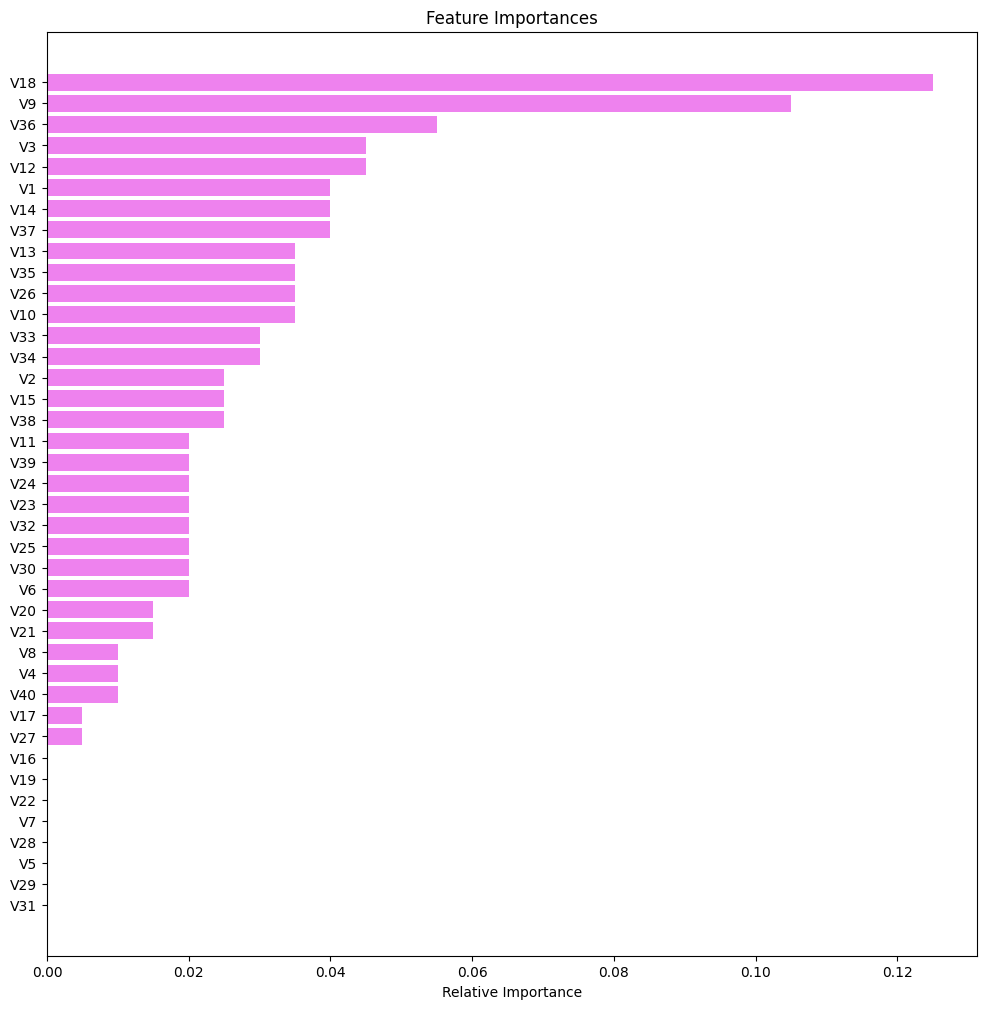

In [ ]:
feature_names = X_train.columns
importances = ada_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- The most important features are V18 and V9 by a very significant margin. Followed by V36, V3 and V12.

Let's see the distributions of these variables and if there are differences when the turbine failed or not.

In [ ]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

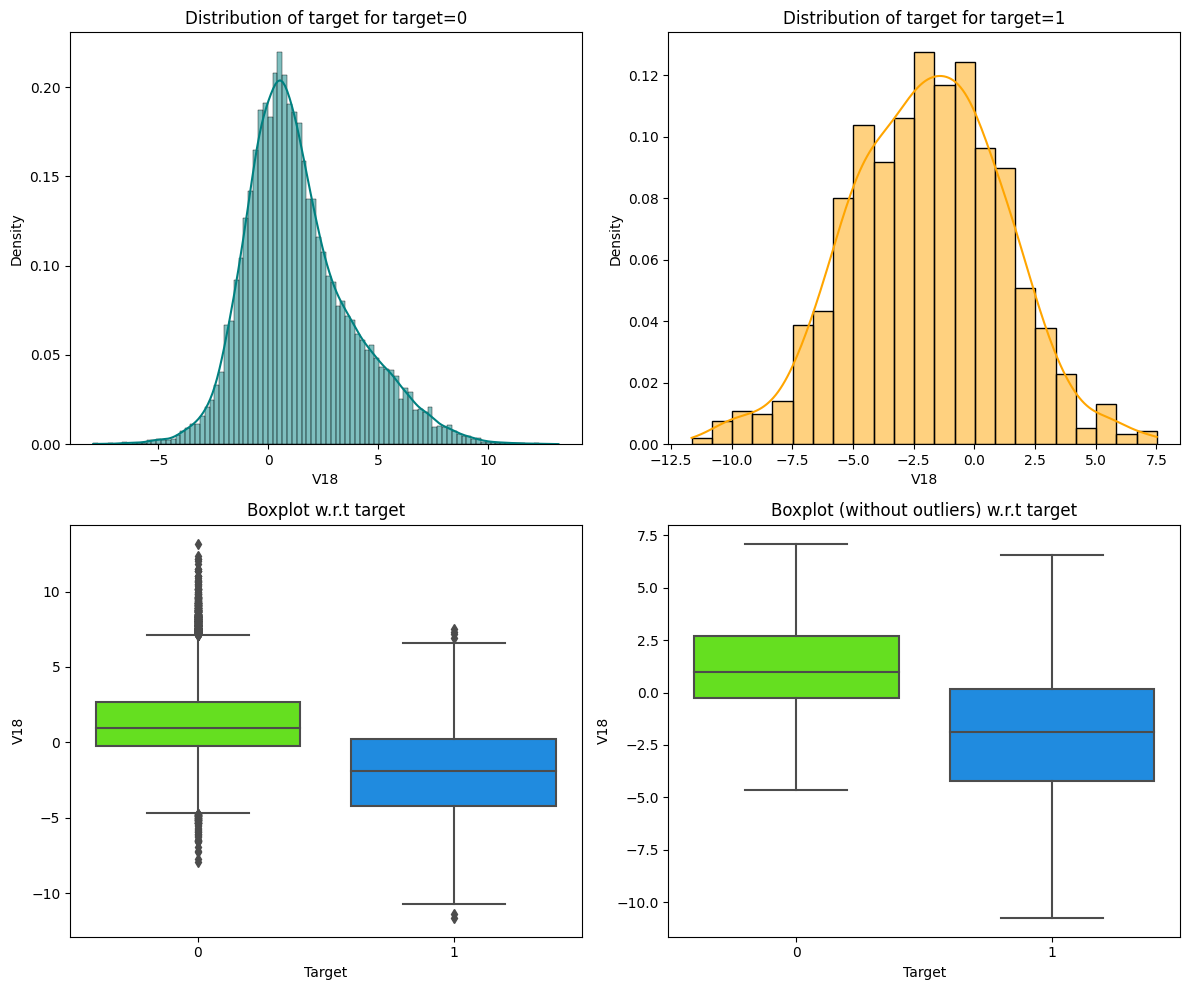

In [ ]:
distribution_plot_wrt_target(df, 'V18', 'Target')

- Overall, when the turbine failed, the values of V18 were on the lower side of the spectrum. -12.5 and 7.5 when it failed, compared to (around) -8 and 18 when it didn't.

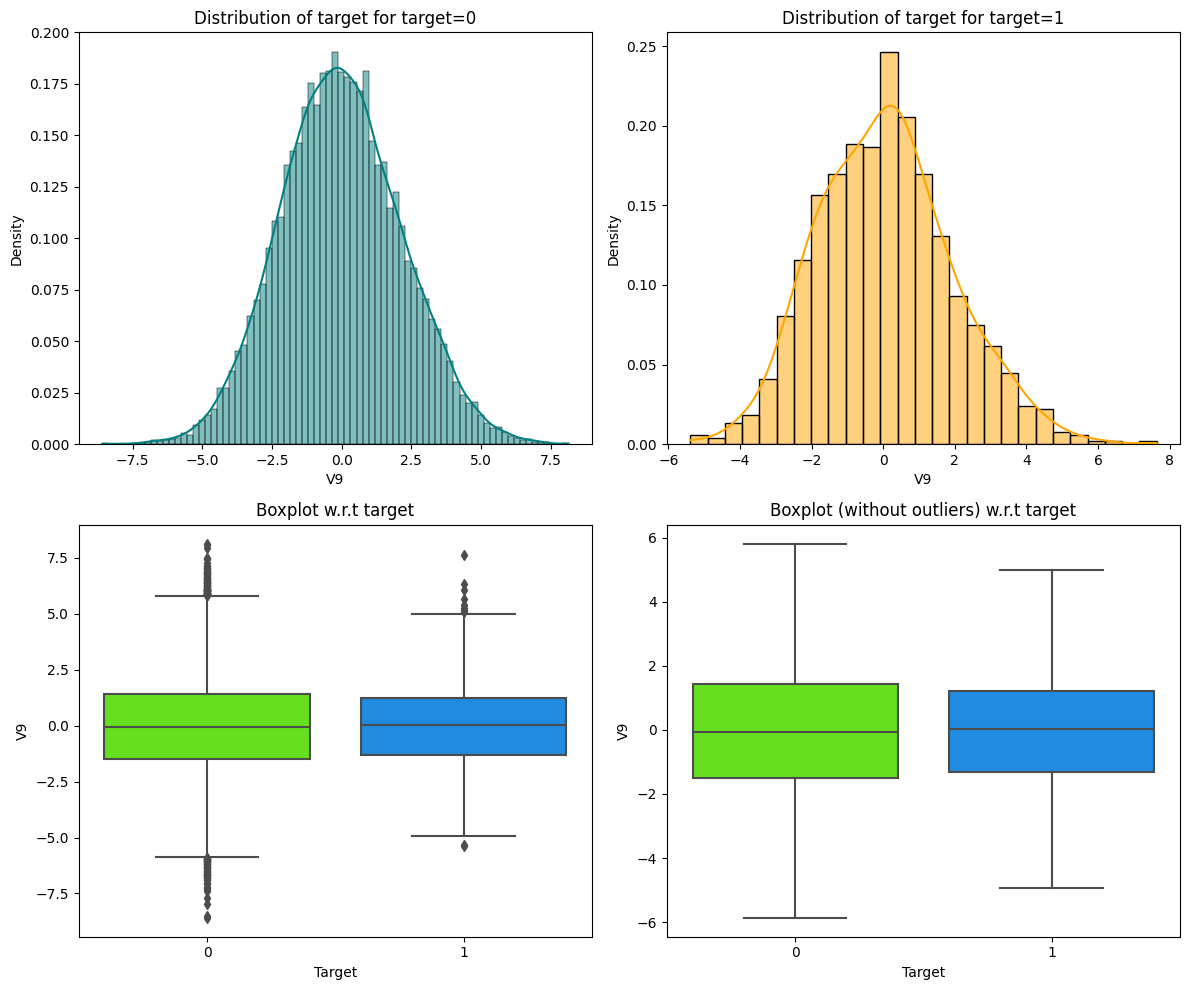

In [ ]:
distribution_plot_wrt_target(df, 'V9', 'Target')

- The distribution of turbines that failed have slight lower range and less outliers.

## Pipelines to build the final model


In [ ]:
Pipeline_model = Pipeline([('imputer', SimpleImputer(strategy='median')),('ada_tuned', AdaBoostClassifier(
    n_estimators=200, learning_rate=0.2, base_estimator=DecisionTreeClassifier(max_depth=1, random_state=1)
))])

In [ ]:
# First, we separate the training dataset
X1 = df.drop(columns="Target")
Y1 = df["Target"]

# We do the same with the test dataset

X_test1 = df_test.drop('Target', axis=1)
y_test1 = df_test['Target']

In [ ]:
# Let's treat the missing values in the train set. The missing values on the test data will be treated in the fit and transformation process
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

In [ ]:
# Now we do oversampling, since the best model was trained with oversampled data

# Synthetic Minority Over Sampling Technique

sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_over1, y_over1 = sm.fit_resample(X1, Y1)

In [ ]:
Pipeline_model.fit(X_over1, y_over1)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('ada_tuned',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                          random_state=1),
                                    learning_rate=0.2, n_estimators=200))])

In [ ]:
Pipeline_model_test = model_performance_classification_sklearn(Pipeline_model, X_test1, y_test1)
Pipeline_model_test

,Accuracy,Recall,Precision,F1
0,0.927,0.837,0.426,0.565


## Business Insights and Conclusions

We were able to build multiple well-performing models, all with high recall scores. The most consistent models were:

- AdaBoost with Oversampled data
- Gradient Boosting with Oversampled data.

Ultimately AdaBoost had a slight better performance on the recall test set score, and had less overfitting. For those reasons it was selected as the final model. The model minimizes FN, which represent the highest cost for ReneWind.

On the test set, the model had an Accuracy of 92.7%, recall score of 83.7%, precision score of 42.6%, and F1-score of 56.5%. The model is able to generalize well and make predictions.

If there's more tolerance for overfitting, the Gradient Boosting model could be implemented too.

Finally, the most important features identified by the model were V18 and V9. The most significant difference is that when the turbines failed, V18 reported lower values, shifting the distribution slightly to the left side.

***